In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from datetime import datetime

from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error, 
                             mean_squared_error, r2_score, accuracy_score,
                             classification_report, confusion_matrix)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, MinMaxScaler,
                                   LabelEncoder, PolynomialFeatures, KBinsDiscretizer)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import STL
import re
import os


# 1. Data Collection & Preparation  


# Data Extraction

In [67]:
import requests
from bs4 import BeautifulSoup
import csv

# Function to scrape data from the website
def scrape_data(url):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if request was successful
    if response.status_code == 200:
        # Parse HTML content
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the table containing house sale data
        table = soup.find('table')
        
        # Extract table headers
        headers = [th.text.strip() for th in table.find_all('th')]
        
        # Extract table rows
        rows = []
        for tr in table.find_all('tr'):
            row = [td.text.strip() for td in tr.find_all('td')]
            if row:  # Check if row is not empty
                rows.append(row)
        
        return headers, rows
    else:
        print("Failed to fetch data from the website.")
        return None, None

# Function to save data as CSV file
def save_as_csv(headers, rows, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(headers)
        writer.writerows(rows)
    print(f"Data saved successfully as {filename}")

# Main function
def main():
    url = "http://mlg.ucd.ie/modules/python/housing/"
    headers, rows = scrape_data(url)
    if headers and rows:
        save_as_csv(headers, rows, "house_sale_data.csv")

if __name__ == "__main__":
    main()


Data saved successfully as house_sale_data.csv


In [68]:
House_data=pd.read_csv("C:/Users/HP/house_sale_data.csv")

In [69]:
House_data

,Date of Sale,Location,Price,Year Built,Size,Description
0,"06 Jan, 2020",West End,"€732,986.00",2010,"1,696 sq ft",Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...
1,06 Jan 2020,West End,"€985,889.00",2004,"2,355 sq ft",Type: Detached; Style: 2-Storey; 4 Bedrooms; 2...
2,07 Jan 20,Brookville,"€1,047,124.00",2013,"1,836 sq ft",Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...
3,"07 Jan, 2020",Brookville,"€516,439.00",2000,"1,000 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...
4,16 Jan 2020,Brookville,"€890,423.00",2011,"1,536 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...
...,...,...,...,...,...,...
1004,20 Dec 2023,Rivermount,"€466,443.00",1936,"1,240 sqft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...
1005,24 Dec 2023,Clarawood,"€662,985.00",1970,"1,499 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...
1006,24 Dec 2023,Clarawood,"€639,980.00",1969,"1,525",Type: Detached; 1 Bathroom; Style: 1-Storey; 2...
1007,31 Dec 2023,Maple Ridge,"€1,131,122.00",2016,"1,339",Type: Semi-Detached; Style: 1-Storey; 2 Bedroo...


# Data cleaning 

In [70]:
# Convert 'Date of Sale' column to datetime
House_data['Date of Sale'] = pd.to_datetime(House_data['Date of Sale'], errors='coerce')

# Format datetime column to desired format
House_data['Date of Sale'] = House_data['Date of Sale'].dt.strftime('%d/%m/%Y')

# Display the updated DataFram
House_data=pd.DataFrame(House_data)
House_data

,Date of Sale,Location,Price,Year Built,Size,Description
0,06/01/2020,West End,"€732,986.00",2010,"1,696 sq ft",Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...
1,06/01/2020,West End,"€985,889.00",2004,"2,355 sq ft",Type: Detached; Style: 2-Storey; 4 Bedrooms; 2...
2,07/01/2020,Brookville,"€1,047,124.00",2013,"1,836 sq ft",Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...
3,07/01/2020,Brookville,"€516,439.00",2000,"1,000 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...
4,16/01/2020,Brookville,"€890,423.00",2011,"1,536 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...
...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,"€466,443.00",1936,"1,240 sqft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...
1005,24/12/2023,Clarawood,"€662,985.00",1970,"1,499 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...
1006,24/12/2023,Clarawood,"€639,980.00",1969,"1,525",Type: Detached; 1 Bathroom; Style: 1-Storey; 2...
1007,31/12/2023,Maple Ridge,"€1,131,122.00",2016,"1,339",Type: Semi-Detached; Style: 1-Storey; 2 Bedroo...


In [71]:
# Remove Euro symbol from 'Price' column
House_data['Price'] = House_data['Price'].str.replace('€', '')

# Remove commas from 'Price' column
House_data['Price'] = House_data['Price'].str.replace(',', '')

# Remove floating point from 'Price' column
House_data['Price'] = House_data['Price'].str.split('.', expand=True)[0]

# Convert the 'Price' column to numeric type
House_data['Price'] = pd.to_numeric(House_data['Price'])

# Display the updated DataFrame
House_data=pd.DataFrame(House_data)
House_data


,Date of Sale,Location,Price,Year Built,Size,Description
0,06/01/2020,West End,732986,2010,"1,696 sq ft",Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...
1,06/01/2020,West End,985889,2004,"2,355 sq ft",Type: Detached; Style: 2-Storey; 4 Bedrooms; 2...
2,07/01/2020,Brookville,1047124,2013,"1,836 sq ft",Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...
3,07/01/2020,Brookville,516439,2000,"1,000 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...
4,16/01/2020,Brookville,890423,2011,"1,536 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...
...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,"1,240 sqft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...
1005,24/12/2023,Clarawood,662985,1970,"1,499 sq ft",Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...
1006,24/12/2023,Clarawood,639980,1969,"1,525",Type: Detached; 1 Bathroom; Style: 1-Storey; 2...
1007,31/12/2023,Maple Ridge,1131122,2016,"1,339",Type: Semi-Detached; Style: 1-Storey; 2 Bedroo...


In [72]:
# Remove 'sq ft' and 'sqft' from 'Size' column
House_data['Size'] = House_data['Size'].str.replace(' sq ft', '').str.replace(' sqft', '')

# Remove commas from 'Size' column
House_data['Size'] = House_data['Size'].str.replace(',', '')

# Convert the 'Size' column to numeric type
House_data['Size'] = pd.to_numeric(House_data['Size'])

# Display the updated DataFrame
House_data=pd.DataFrame(House_data)
House_data

,Date of Sale,Location,Price,Year Built,Size,Description
0,06/01/2020,West End,732986,2010,1696,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...
1,06/01/2020,West End,985889,2004,2355,Type: Detached; Style: 2-Storey; 4 Bedrooms; 2...
2,07/01/2020,Brookville,1047124,2013,1836,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...
3,07/01/2020,Brookville,516439,2000,1000,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...
4,16/01/2020,Brookville,890423,2011,1536,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...
...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...
1005,24/12/2023,Clarawood,662985,1970,1499,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...
1006,24/12/2023,Clarawood,639980,1969,1525,Type: Detached; 1 Bathroom; Style: 1-Storey; 2...
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Type: Semi-Detached; Style: 1-Storey; 2 Bedroo...


In [73]:


# Define a function to extract type from the description
def extract_type(description):
    match = re.search(r'Type:\s*([\w\s-]+)', description)
    if match:
        return match.group(1)
    else:
        return None

# Define a function to extract style from the description
def extract_style(description):
    match = re.search(r'Style:\s*([\w\s-]+)', description)
    if match:
        return match.group(1)
    else:
        return None

# Define a function to extract bedrooms from the description
def extract_bedrooms(description):
    match = re.search(r'(\d+)\s+Bedrooms', description)
    if match:
        return int(match.group(1))
    else:
        return None

# Define a function to extract bathrooms from the description
def extract_bathrooms(description):
    match = re.search(r'(\d+)\s*Bathrooms?', description)
    if match:
        return int(match.group(1))
    else:
        return None

# Apply the functions to extract type, style, bedrooms, and bathrooms
House_data['Type'] = House_data['Description'].apply(extract_type)
House_data['Style'] = House_data['Description'].apply(extract_style)
House_data['Bedrooms'] = House_data['Description'].apply(extract_bedrooms)
House_data['Bathrooms'] = House_data['Description'].apply(extract_bathrooms)

# Display the updated DataFrame
House_data=pd.DataFrame(House_data)
House_data




,Date of Sale,Location,Price,Year Built,Size,Description,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...,Detached,2-Storey,3.0,2
1,06/01/2020,West End,985889,2004,2355,Type: Detached; Style: 2-Storey; 4 Bedrooms; 2...,Detached,2-Storey,4.0,2
2,07/01/2020,Brookville,1047124,2013,1836,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...,Detached,2-Storey,3.0,2
3,07/01/2020,Brookville,516439,2000,1000,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...,Detached,1-Storey,3.0,1
4,16/01/2020,Brookville,890423,2011,1536,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...,Detached,1-Storey,3.0,2
...,...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...,Detached,1-Storey,3.0,1
1005,24/12/2023,Clarawood,662985,1970,1499,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...,Detached,1-Storey,3.0,2
1006,24/12/2023,Clarawood,639980,1969,1525,Type: Detached; 1 Bathroom; Style: 1-Storey; 2...,Detached,1-Storey,2.0,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Type: Semi-Detached; Style: 1-Storey; 2 Bedroo...,Semi-Detached,1-Storey,2.0,2


In [74]:

unique_types = House_data['Type'].unique()


unique_styles = House_data['Style'].unique()


unique_bedrooms = House_data['Bedrooms'].unique()


unique_bathrooms = House_data['Bathrooms'].unique()


print("Unique Types:", unique_types)
print("Unique Styles:", unique_styles)
print("Unique Bedrooms:", unique_bedrooms)
print("Unique Bathrooms:", unique_bathrooms)


Unique Types: ['Detached' 'Terraced' 'Semi-Detached' 'Bunaglow' 'Duplex' 'Semi-D'
 'End-of-Terrace' None 'EndOfTerrace ']
Unique Styles: ['2-Storey' '1-Storey' 'Two-Storey' 'One-Storey' None 'Dormer']
Unique Bedrooms: [ 3.  4.  2. nan  5.]
Unique Bathrooms: [2 1 3]


In [75]:
# Define a mapping dictionary for styles
style_mapping = {
    '2-Storey': 2,
    'Two-Storey': 2,
    '1-Storey': 1,
    'One-Storey': 1,
    'Dormer': 3,
    None: 0  # Assign 0 for missing values
}


House_data['Style'] = House_data['Style'].map(style_mapping)



House_data=pd.DataFrame(House_data)
House_data


,Date of Sale,Location,Price,Year Built,Size,Description,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...,Detached,2,3.0,2
1,06/01/2020,West End,985889,2004,2355,Type: Detached; Style: 2-Storey; 4 Bedrooms; 2...,Detached,2,4.0,2
2,07/01/2020,Brookville,1047124,2013,1836,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...,Detached,2,3.0,2
3,07/01/2020,Brookville,516439,2000,1000,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...,Detached,1,3.0,1
4,16/01/2020,Brookville,890423,2011,1536,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...,Detached,1,3.0,2
...,...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...,Detached,1,3.0,1
1005,24/12/2023,Clarawood,662985,1970,1499,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...,Detached,1,3.0,2
1006,24/12/2023,Clarawood,639980,1969,1525,Type: Detached; 1 Bathroom; Style: 1-Storey; 2...,Detached,1,2.0,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Type: Semi-Detached; Style: 1-Storey; 2 Bedroo...,Semi-Detached,1,2.0,2


In [76]:


unique_styles = House_data['Style'].unique()
print("Unique Styles:", unique_styles)

Unique Styles: [2 1 0 3]


In [77]:

House_data = House_data[House_data['Style'] != 0]
House_data

,Date of Sale,Location,Price,Year Built,Size,Description,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...,Detached,2,3.0,2
1,06/01/2020,West End,985889,2004,2355,Type: Detached; Style: 2-Storey; 4 Bedrooms; 2...,Detached,2,4.0,2
2,07/01/2020,Brookville,1047124,2013,1836,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...,Detached,2,3.0,2
3,07/01/2020,Brookville,516439,2000,1000,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...,Detached,1,3.0,1
4,16/01/2020,Brookville,890423,2011,1536,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...,Detached,1,3.0,2
...,...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...,Detached,1,3.0,1
1005,24/12/2023,Clarawood,662985,1970,1499,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...,Detached,1,3.0,2
1006,24/12/2023,Clarawood,639980,1969,1525,Type: Detached; 1 Bathroom; Style: 1-Storey; 2...,Detached,1,2.0,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Type: Semi-Detached; Style: 1-Storey; 2 Bedroo...,Semi-Detached,1,2.0,2


In [78]:

House_data['Bedrooms'] = House_data['Bedrooms'].astype('Int64').fillna(0)


House_data['Bathrooms'] = House_data['Bathrooms'].astype('Int64').fillna(0)



# Display the updated DataFrame
House_data=pd.DataFrame(House_data)
House_data



C:\Users\HP\AppData\Local\Temp\ipykernel_18992\720621224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_data['Bedrooms'] = House_data['Bedrooms'].astype('Int64').fillna(0)
C:\Users\HP\AppData\Local\Temp\ipykernel_18992\720621224.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_data['Bathrooms'] = House_data['Bathrooms'].astype('Int64').fillna(0)


,Date of Sale,Location,Price,Year Built,Size,Description,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...,Detached,2,3,2
1,06/01/2020,West End,985889,2004,2355,Type: Detached; Style: 2-Storey; 4 Bedrooms; 2...,Detached,2,4,2
2,07/01/2020,Brookville,1047124,2013,1836,Type: Detached; Style: 2-Storey; 3 Bedrooms; 2...,Detached,2,3,2
3,07/01/2020,Brookville,516439,2000,1000,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...,Detached,1,3,1
4,16/01/2020,Brookville,890423,2011,1536,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...,Detached,1,3,2
...,...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Type: Detached; Style: 1-Storey; 3 Bedrooms; 1...,Detached,1,3,1
1005,24/12/2023,Clarawood,662985,1970,1499,Type: Detached; Style: 1-Storey; 3 Bedrooms; 2...,Detached,1,3,2
1006,24/12/2023,Clarawood,639980,1969,1525,Type: Detached; 1 Bathroom; Style: 1-Storey; 2...,Detached,1,2,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Type: Semi-Detached; Style: 1-Storey; 2 Bedroo...,Semi-Detached,1,2,2


In [79]:

House_data.drop(columns=['Description'], inplace=True)



House_data=pd.DataFrame(House_data)
House_data


,Date of Sale,Location,Price,Year Built,Size,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Detached,2,3,2
1,06/01/2020,West End,985889,2004,2355,Detached,2,4,2
2,07/01/2020,Brookville,1047124,2013,1836,Detached,2,3,2
3,07/01/2020,Brookville,516439,2000,1000,Detached,1,3,1
4,16/01/2020,Brookville,890423,2011,1536,Detached,1,3,2
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Detached,1,3,1
1005,24/12/2023,Clarawood,662985,1970,1499,Detached,1,3,2
1006,24/12/2023,Clarawood,639980,1969,1525,Detached,1,2,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Semi-Detached,1,2,2


In [80]:

unique_types = House_data['Type'].unique()


unique_styles = House_data['Style'].unique()


unique_bedrooms = House_data['Bedrooms'].unique()

unique_bathrooms = House_data['Bathrooms'].unique()

print("Unique Types:", unique_types)
print("Unique Styles:", unique_styles)
print("Unique Bedrooms:", unique_bedrooms)
print("Unique Bathrooms:", unique_bathrooms)


Unique Types: ['Detached' 'Terraced' 'Semi-Detached' 'Bunaglow' 'Duplex' 'Semi-D'
 'End-of-Terrace' None 'EndOfTerrace ']
Unique Styles: [2 1 3]
Unique Bedrooms: <IntegerArray>
[3, 4, 2, 0, 5]
Length: 5, dtype: Int64
Unique Bathrooms: <IntegerArray>
[2, 1, 3]
Length: 3, dtype: Int64


In [81]:

zero_bedroom_rows = House_data[House_data['Bedrooms'] == 0]

zero_bedroom_rows.count()

Date of Sale    27
Location        27
Price           27
Year Built      27
Size            27
Type            26
Style           27
Bedrooms        27
Bathrooms       27
dtype: int64

In [82]:

House_data = House_data[House_data['Bedrooms'] != 0]


House_data

,Date of Sale,Location,Price,Year Built,Size,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Detached,2,3,2
1,06/01/2020,West End,985889,2004,2355,Detached,2,4,2
2,07/01/2020,Brookville,1047124,2013,1836,Detached,2,3,2
3,07/01/2020,Brookville,516439,2000,1000,Detached,1,3,1
4,16/01/2020,Brookville,890423,2011,1536,Detached,1,3,2
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Detached,1,3,1
1005,24/12/2023,Clarawood,662985,1970,1499,Detached,1,3,2
1006,24/12/2023,Clarawood,639980,1969,1525,Detached,1,2,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Semi-Detached,1,2,2


In [83]:

unique_types = House_data['Type'].unique()


unique_styles = House_data['Style'].unique()


unique_bedrooms = House_data['Bedrooms'].unique()


unique_bathrooms = House_data['Bathrooms'].unique()


print("Unique Types:", unique_types)
print("Unique Styles:", unique_styles)
print("Unique Bedrooms:", unique_bedrooms)
print("Unique Bathrooms:", unique_bathrooms)


Unique Types: ['Detached' 'Terraced' 'Semi-Detached' 'Bunaglow' 'Duplex' 'Semi-D'
 'End-of-Terrace' None 'EndOfTerrace ']
Unique Styles: [2 1 3]
Unique Bedrooms: <IntegerArray>
[3, 4, 2, 5]
Length: 4, dtype: Int64
Unique Bathrooms: <IntegerArray>
[2, 1, 3]
Length: 3, dtype: Int64


In [84]:
# Get unique values from the 'Type' column
unique_Location =House_data['Location'].unique()
unique_Location

array(['West End', 'Brookville', 'Clarawood', 'Maple Ridge', 'Rivermount',
       'Mile End', 'Redbridge'], dtype=object)

In [85]:
# Correcting Semi-D and EndOfTerrace in the 'Type' column
House_data['Type'] = House_data['Type'].replace({'Semi-D': 'Semi-Detached', 'EndOfTerrace ': 'End-of-Terrace','Bunaglow':'Bungalow'})

House_data=pd.DataFrame(House_data)
House_data


C:\Users\HP\AppData\Local\Temp\ipykernel_18992\1435439012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_data['Type'] = House_data['Type'].replace({'Semi-D': 'Semi-Detached', 'EndOfTerrace ': 'End-of-Terrace','Bunaglow':'Bungalow'})


,Date of Sale,Location,Price,Year Built,Size,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Detached,2,3,2
1,06/01/2020,West End,985889,2004,2355,Detached,2,4,2
2,07/01/2020,Brookville,1047124,2013,1836,Detached,2,3,2
3,07/01/2020,Brookville,516439,2000,1000,Detached,1,3,1
4,16/01/2020,Brookville,890423,2011,1536,Detached,1,3,2
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Detached,1,3,1
1005,24/12/2023,Clarawood,662985,1970,1499,Detached,1,3,2
1006,24/12/2023,Clarawood,639980,1969,1525,Detached,1,2,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Semi-Detached,1,2,2


In [86]:

unique_types = House_data['Type'].unique()
unique_types

array(['Detached', 'Terraced', 'Semi-Detached', 'Bungalow', 'Duplex',
       'End-of-Terrace', None], dtype=object)

In [87]:

House_data = House_data[House_data['Type'].notna()]


House_data


,Date of Sale,Location,Price,Year Built,Size,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Detached,2,3,2
1,06/01/2020,West End,985889,2004,2355,Detached,2,4,2
2,07/01/2020,Brookville,1047124,2013,1836,Detached,2,3,2
3,07/01/2020,Brookville,516439,2000,1000,Detached,1,3,1
4,16/01/2020,Brookville,890423,2011,1536,Detached,1,3,2
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Detached,1,3,1
1005,24/12/2023,Clarawood,662985,1970,1499,Detached,1,3,2
1006,24/12/2023,Clarawood,639980,1969,1525,Detached,1,2,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Semi-Detached,1,2,2


In [88]:

unique_types = House_data['Type'].unique()
unique_types

array(['Detached', 'Terraced', 'Semi-Detached', 'Bungalow', 'Duplex',
       'End-of-Terrace'], dtype=object)

# 2. Feature Associations & Regression

# Data Visualization

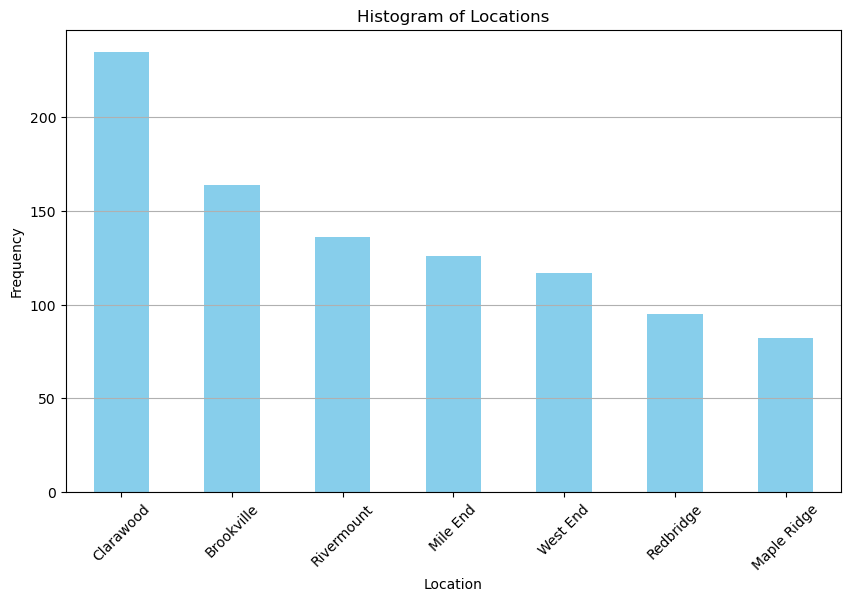

In [89]:
# Plot histogram for locations
plt.figure(figsize=(10, 6))
House_data['Location'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Histogram of Locations')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

tick_positions = range(len(House_data['Location'].value_counts()))
tick_labels = House_data['Location'].value_counts().index

plt.xticks(tick_positions, tick_labels)

plt.grid(axis='y')
plt.show()


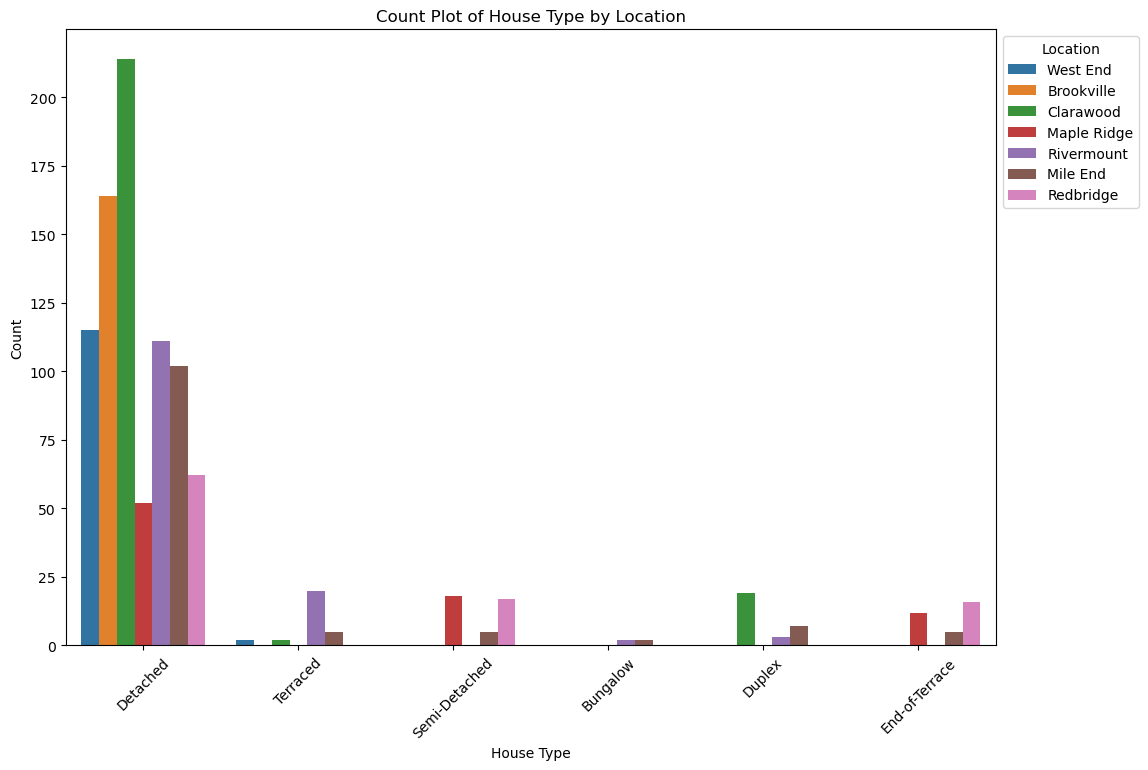

In [90]:
# Count plot of house type by location
plt.figure(figsize=(12, 8))
sns.countplot(x='Type', hue='Location', data=House_data)
plt.title('Count Plot of House Type by Location')
plt.xlabel('House Type')
plt.ylabel('Count')
plt.legend(title='Location', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

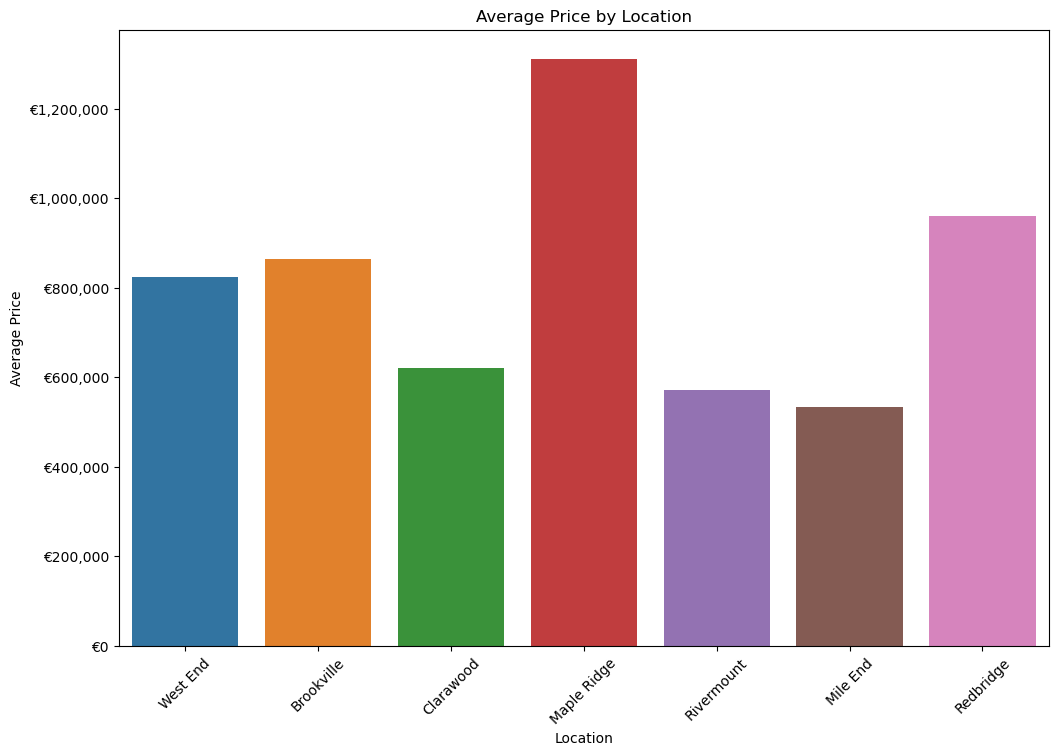

In [91]:
# Define a function to format y-axis tick labels
def format_ticks(value, pos):
    return f'€{value:,.0f}'

# Create a bar plot of average price by location
plt.figure(figsize=(12, 8))
sns.barplot(x='Location', y='Price', data=House_data, ci=None)
plt.title('Average Price by Location')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))  # Apply custom formatting to y-axis tick labels
plt.show()


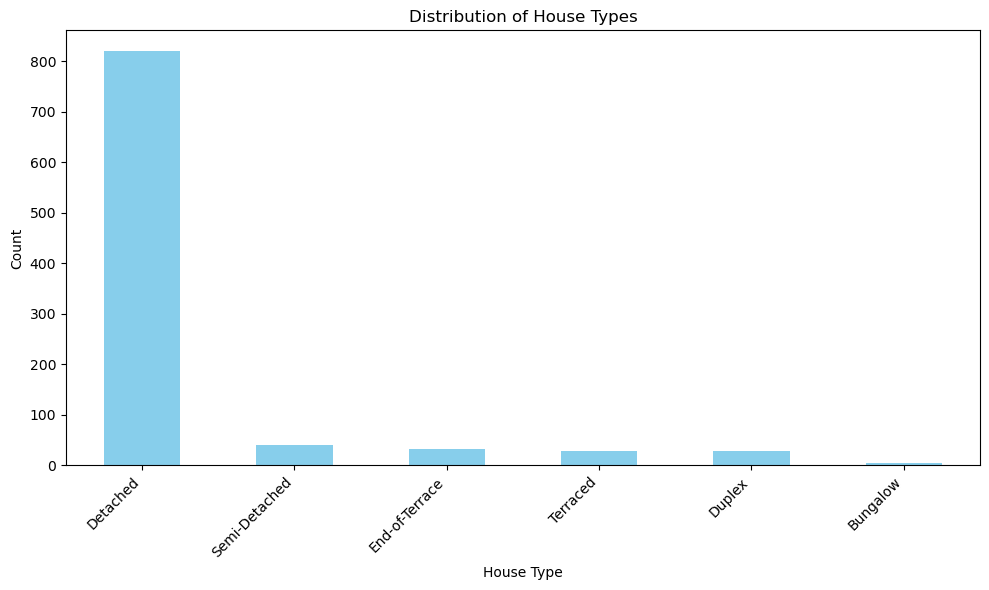

In [92]:

house_type_counts = House_data['Type'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
house_type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of House Types')
plt.xlabel('House Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


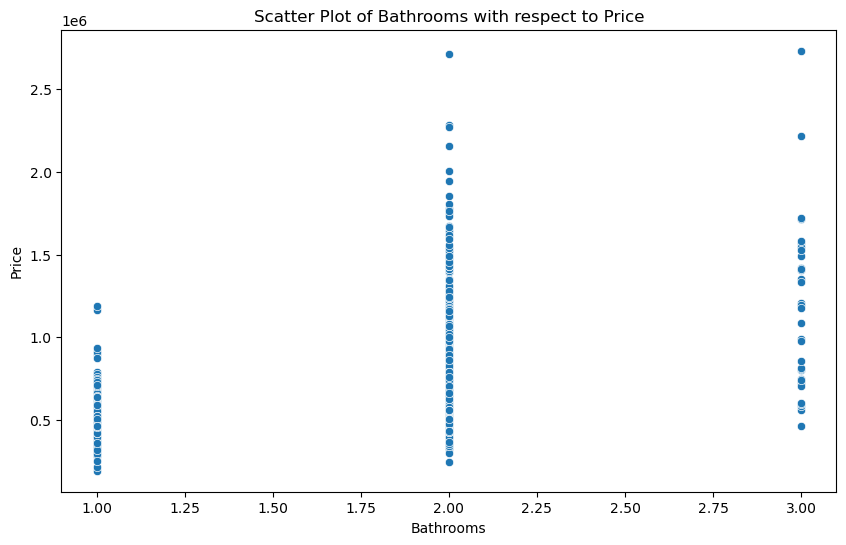

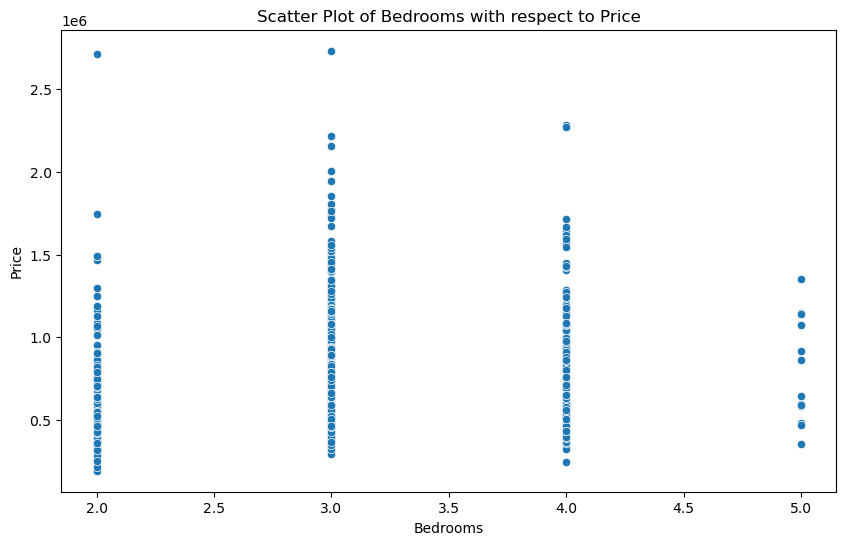

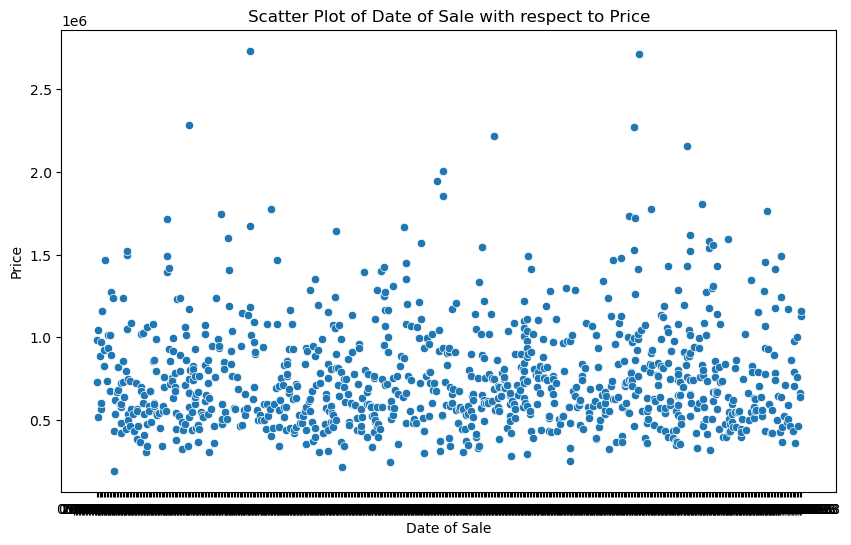

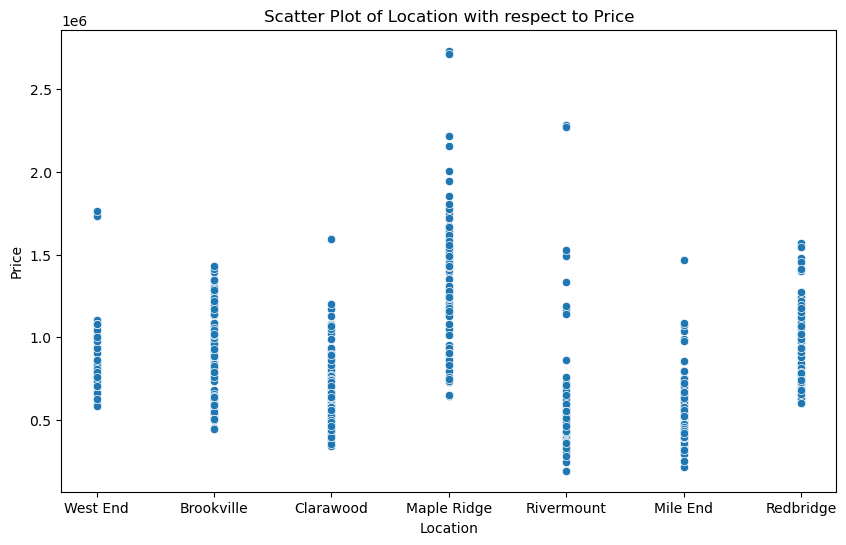

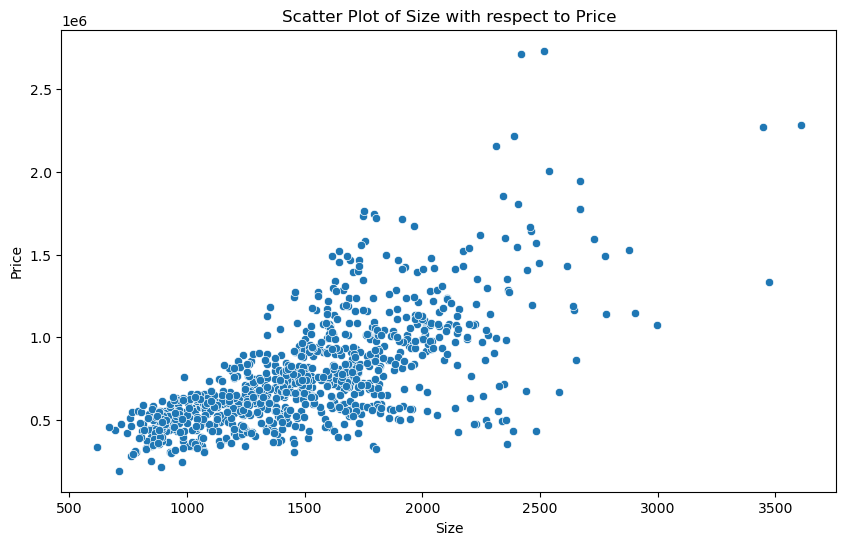

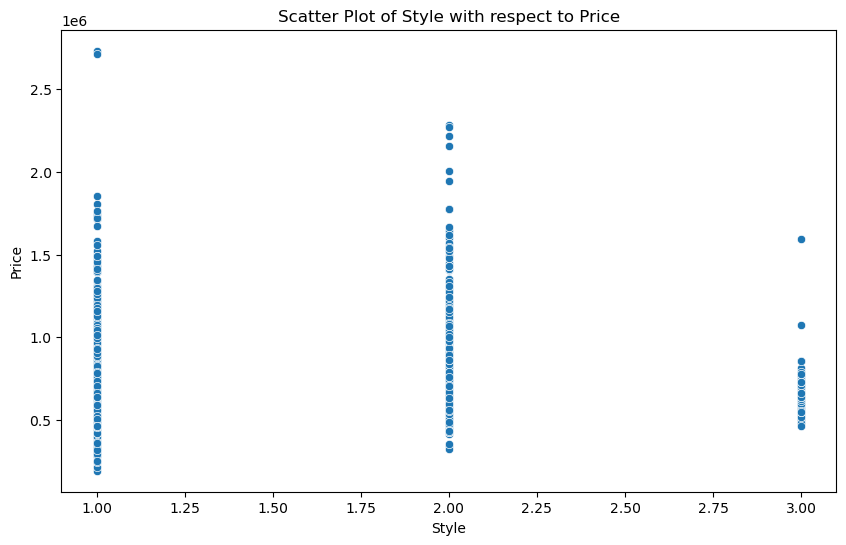

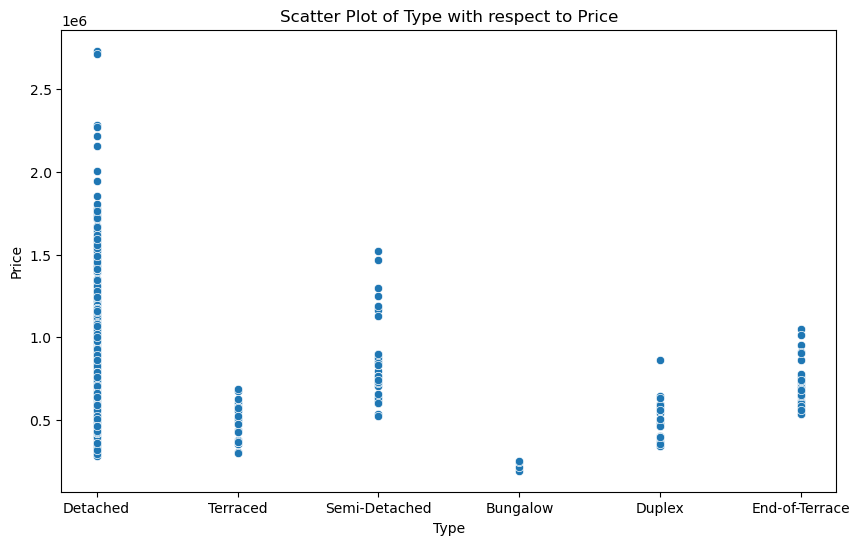

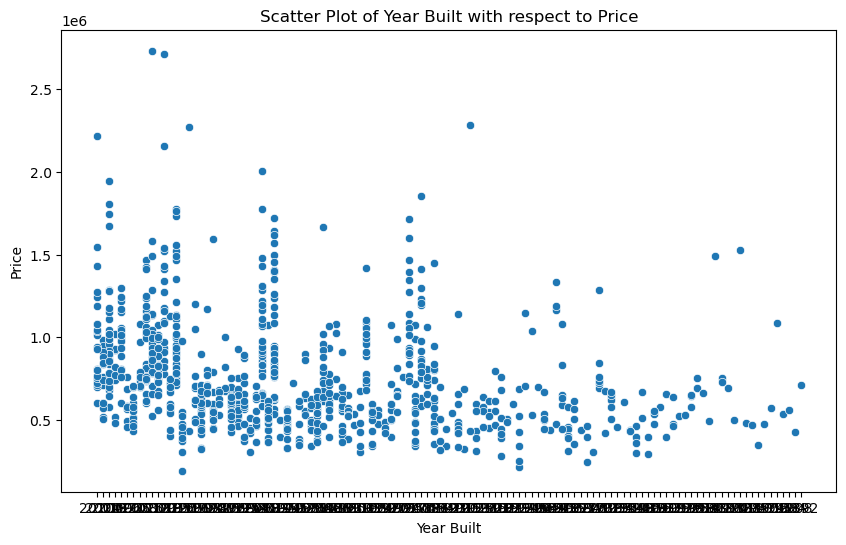

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns


columns_to_plot = House_data.columns.difference(['Price'])


for column in columns_to_plot:
    # Create a new figure for each plot
    plt.figure(figsize=(10, 6))
    
    # Create a scatter plot for the current column
    sns.scatterplot(x=House_data[column], y=House_data['Price'])
    
    # Set title and labels
    plt.title(f'Scatter Plot of {column} with respect to Price')
    plt.xlabel(column)
    plt.ylabel('Price')
    
    # Show plot
    plt.show()


In [94]:
House_data['Year Built'] = pd.to_numeric(House_data['Year Built'], errors='coerce').astype('Int64')

C:\Users\HP\AppData\Local\Temp\ipykernel_18992\1398364200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_data['Year Built'] = pd.to_numeric(House_data['Year Built'], errors='coerce').astype('Int64')


In [95]:
House_data.dtypes

Date of Sale    object
Location        object
Price            int64
Year Built       Int64
Size             int64
Type            object
Style            int64
Bedrooms         Int64
Bathrooms        Int64
dtype: object

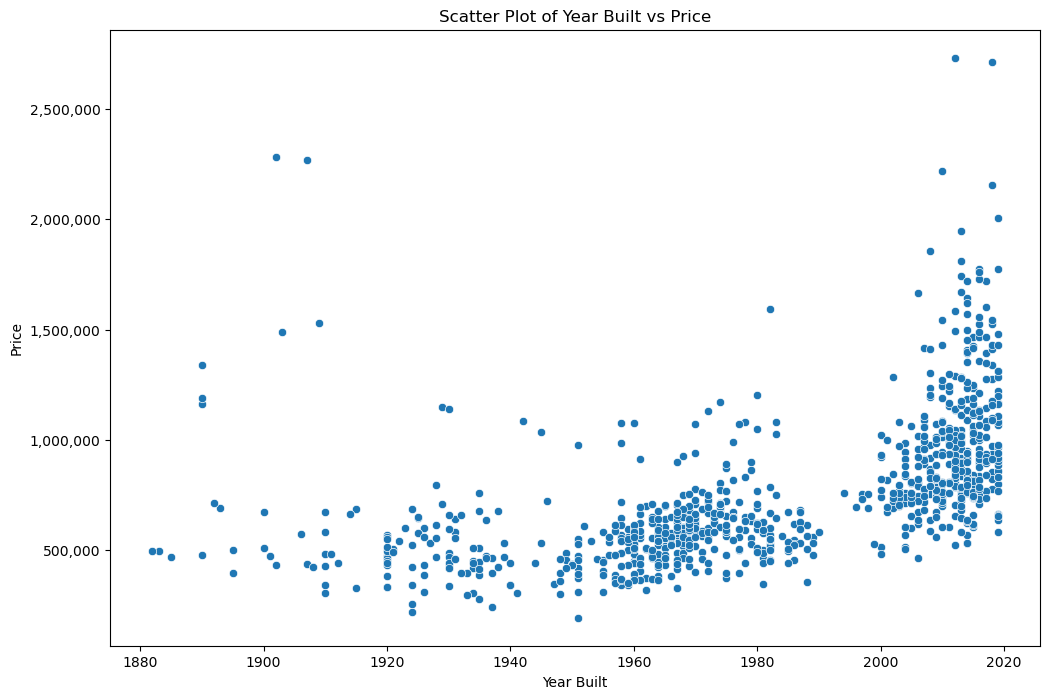

In [96]:



plt.figure(figsize=(12, 8))
sns.scatterplot(x='Year Built', y='Price', data=House_data)

# Adding labels and title
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.title('Scatter Plot of Year Built vs Price')

# Set formatter for price axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Show plot
plt.show()


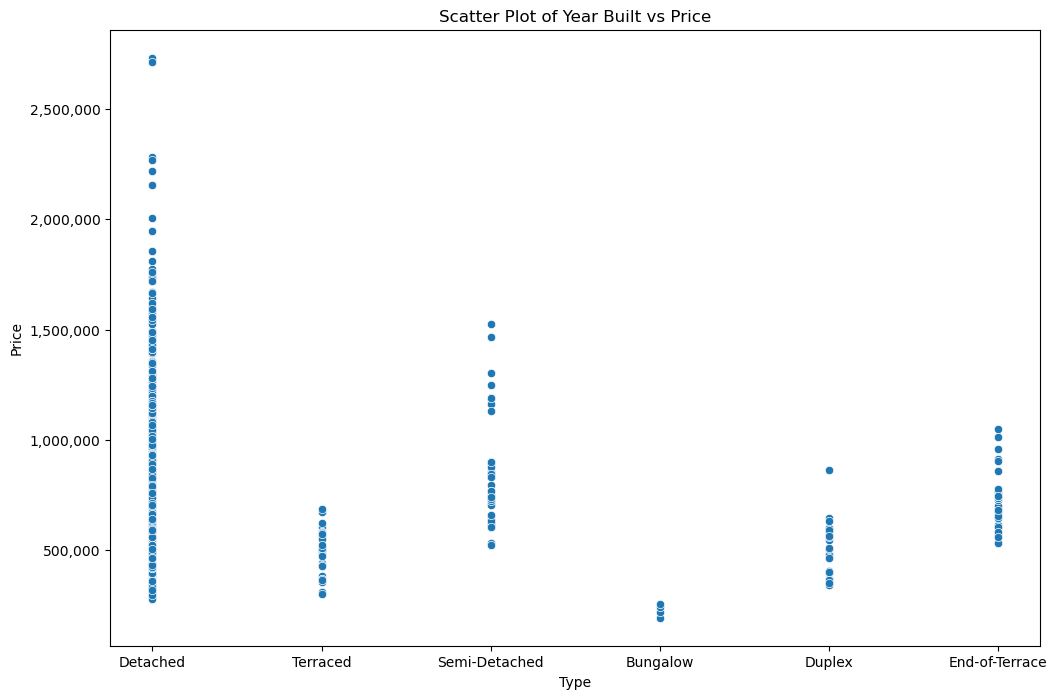

In [97]:

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Type', y='Price', data=House_data)

# Adding labels and title
plt.xlabel('Type')
plt.ylabel('Price')
plt.title('Scatter Plot of Year Built vs Price')

# Set formatter for price axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Show plot
plt.show()


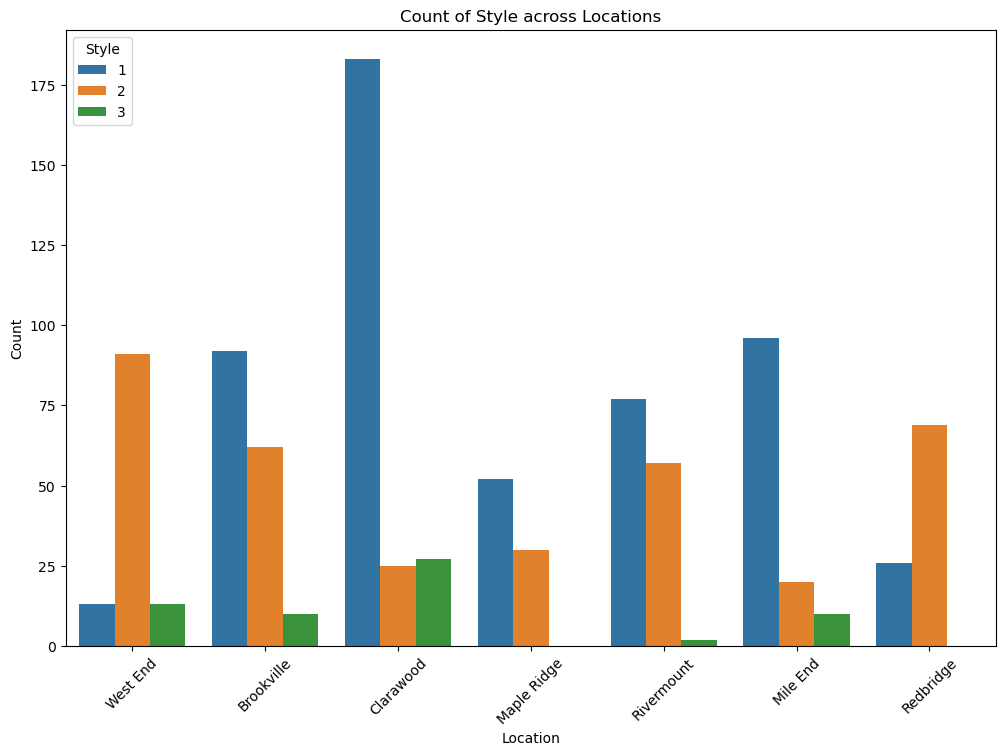

In [98]:
# Create count plot to visualize the distribution of Style across Location categories
plt.figure(figsize=(12, 8))
sns.countplot(x='Location', hue='Style', data=House_data)

# Adding labels and title
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Count of Style across Locations')

# Show plot
plt.legend(title='Style')
plt.xticks(rotation=45)  
plt.show()


In [99]:
# Filter rows where Bedroom = 0
zero_bedroom_rows = House_data[House_data['Bedrooms'] == 0]

# Display the filtered rows
zero_bedroom_rows.count()


Date of Sale    0
Location        0
Price           0
Year Built      0
Size            0
Type            0
Style           0
Bedrooms        0
Bathrooms       0
dtype: int64

In [100]:
House_data.columns

Index(['Date of Sale', 'Location', 'Price', 'Year Built', 'Size', 'Type',
       'Style', 'Bedrooms', 'Bathrooms'],
      dtype='object')

# Regression
## Size vs Price 

In [101]:
y = House_data['Price']
X = House_data['Size']


In [102]:
X

0       1696
1       2355
2       1836
3       1000
4       1536
        ... 
1004    1240
1005    1499
1006    1525
1007    1339
1008    1713
Name: Size, Length: 955, dtype: int64

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=2529)

In [104]:
# check shape of train and test sample
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668,), (287,), (668,), (287,))

In [105]:

X_train = np.array(X_train).reshape(-1, 1)  

In [106]:

model = LinearRegression()

In [107]:

model.fit(X_train,y_train)

LinearRegression()

In [108]:
model.intercept_

39244.567566781654

In [109]:
model.coef_

array([477.63997409])

In [110]:
# Step 7 : predict model
y_pred = model.predict(X_test)

In [111]:
y_pred

array([ 400818.02795475,  804901.44603695,  692656.05212523,
        843112.64396435,  748539.92909405,  993569.23580346,
        909982.24033729,  812066.04564834,  834037.48445659,
        882279.12183993,  801080.32624421,  625786.45575229,
        540766.54036384,  612412.5364777 ,  840724.44409389,
        803468.52611468,  806334.36595923,  863651.16285032,
        509719.94204783,  698865.37178843,  718448.61072622,
        700298.29171071, 1144981.10759077,  999778.55546667,
        577544.81836895,  489659.06313595,  556528.65950889,
        760958.56842045,  479150.98370591,  536467.78059701,
        719881.5306485 , 1015540.67461172,  768123.16803184,
       1077156.23126964,  575156.61849849,  745196.4492754 ,
        702208.85160708,  720359.17062259,  993091.59582937,
        736121.28976764,  954880.39790198,  788184.04694372,
        877025.08212491,  840246.80411979,  663042.3737315 ,
        658265.97399058,  958223.87772062,  676416.29300609,
        916191.56000049,

In [112]:
mean_absolute_error(y_test,y_pred)

161913.15224200196

In [113]:
mean_absolute_percentage_error(y_test,y_pred)

0.2246393466916432

In [114]:
mean_squared_error(y_test,y_pred)

53192026293.456184

In [115]:
# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

R-squared: 0.5158131941747359


## Style vs Price

In [116]:
y = House_data['Price']
X = House_data['Style']

In [117]:
X

0       2
1       2
2       2
3       1
4       1
       ..
1004    1
1005    1
1006    1
1007    1
1008    1
Name: Style, Length: 955, dtype: int64

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=2529)

In [119]:
# check shape of train and test sample
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668,), (287,), (668,), (287,))

In [120]:
# Reshape X_train
X_train = np.array(X_train).reshape(-1, 1) 
X_test=np.array(X_test).reshape(-1, 1)

In [121]:

model = LinearRegression()

In [122]:

model.fit(X_train,y_train)

LinearRegression()

In [123]:
model.intercept_

643157.8867958605

In [124]:
model.coef_

array([73467.1779335])

In [125]:

y_pred = model.predict(X_test)

In [126]:
y_pred

array([716625.06472936, 790092.24266286, 716625.06472936, 716625.06472936,
       790092.24266286, 790092.24266286, 790092.24266286, 716625.06472936,
       716625.06472936, 790092.24266286, 790092.24266286, 716625.06472936,
       716625.06472936, 716625.06472936, 863559.42059636, 790092.24266286,
       716625.06472936, 790092.24266286, 863559.42059636, 790092.24266286,
       716625.06472936, 790092.24266286, 790092.24266286, 790092.24266286,
       716625.06472936, 863559.42059636, 716625.06472936, 790092.24266286,
       716625.06472936, 716625.06472936, 790092.24266286, 790092.24266286,
       716625.06472936, 790092.24266286, 716625.06472936, 716625.06472936,
       716625.06472936, 790092.24266286, 790092.24266286, 716625.06472936,
       790092.24266286, 716625.06472936, 716625.06472936, 790092.24266286,
       716625.06472936, 716625.06472936, 863559.42059636, 790092.24266286,
       790092.24266286, 716625.06472936, 790092.24266286, 716625.06472936,
       790092.24266286, 7

In [127]:
mean_absolute_error(y_test,y_pred)

235305.28160382074

In [128]:
mean_absolute_percentage_error(y_test,y_pred)

0.3208619653658417

In [129]:
mean_squared_error(y_test,y_pred)

108037466838.35138

In [130]:
# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

R-squared: 0.016575986608925453


## Beadroom vs price

In [131]:
y = House_data['Price']
X = House_data['Bedrooms']

In [132]:
X

0       3
1       4
2       3
3       3
4       3
       ..
1004    3
1005    3
1006    2
1007    2
1008    3
Name: Bedrooms, Length: 955, dtype: Int64

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=2529)

In [134]:
# check shape of train and test sample
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668,), (287,), (668,), (287,))

In [135]:
# Reshape X_train
X_train = np.array(X_train).reshape(-1, 1)  
X_test=np.array(X_test).reshape(-1, 1) 

In [136]:
model = LinearRegression()

In [137]:
model.fit(X_train,y_train)

LinearRegression()

In [138]:
model.intercept_

440780.567938033

In [139]:
model.coef_

array([105861.44424944])

In [140]:
y_pred = model.predict(X_test)

In [141]:
y_pred

array([652503.45643691, 758364.90068634, 652503.45643691, 652503.45643691,
       758364.90068634, 758364.90068634, 864226.34493578, 758364.90068634,
       970087.78918521, 758364.90068634, 864226.34493578, 652503.45643691,
       652503.45643691, 652503.45643691, 758364.90068634, 758364.90068634,
       758364.90068634, 758364.90068634, 758364.90068634, 758364.90068634,
       864226.34493578, 758364.90068634, 758364.90068634, 758364.90068634,
       758364.90068634, 652503.45643691, 758364.90068634, 758364.90068634,
       758364.90068634, 758364.90068634, 758364.90068634, 758364.90068634,
       758364.90068634, 758364.90068634, 652503.45643691, 758364.90068634,
       758364.90068634, 758364.90068634, 758364.90068634, 758364.90068634,
       864226.34493578, 758364.90068634, 758364.90068634, 758364.90068634,
       758364.90068634, 758364.90068634, 864226.34493578, 758364.90068634,
       758364.90068634, 758364.90068634, 864226.34493578, 864226.34493578,
       758364.90068634, 6

In [142]:
mean_absolute_error(y_test,y_pred)

233751.8310941532

In [143]:
mean_absolute_percentage_error(y_test,y_pred)

0.3215289772483283

In [144]:
mean_squared_error(y_test,y_pred)

107482271661.3561

In [145]:
# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

R-squared: 0.021629717366913326


# Bathroom Vs Price

In [146]:
y = House_data['Price']
X = House_data['Bathrooms']

In [147]:
X

0       2
1       2
2       2
3       1
4       2
       ..
1004    1
1005    2
1006    1
1007    2
1008    2
Name: Bathrooms, Length: 955, dtype: Int64

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=2529)

In [149]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668,), (287,), (668,), (287,))

In [150]:
# Reshape X_train
X_train = np.array(X_train).reshape(-1, 1) 
X_test=np.array(X_test).reshape(-1, 1)  

In [151]:
model = LinearRegression()

In [152]:
model.fit(X_train,y_train)

LinearRegression()

In [153]:
model.intercept_

215927.27677165356

In [154]:
model.coef_

array([330168.03700787])

In [155]:
y_pred = model.predict(X_test)

In [156]:
y_pred

array([ 546095.31377953,  876263.3507874 ,  546095.31377953,
        876263.3507874 ,  876263.3507874 ,  876263.3507874 ,
        876263.3507874 ,  876263.3507874 ,  876263.3507874 ,
        876263.3507874 ,  546095.31377953,  546095.31377953,
        546095.31377953, 1206431.38779528,  546095.31377953,
        876263.3507874 ,  876263.3507874 ,  876263.3507874 ,
        546095.31377953,  876263.3507874 ,  546095.31377953,
        876263.3507874 ,  876263.3507874 ,  876263.3507874 ,
        546095.31377953,  546095.31377953,  546095.31377953,
        876263.3507874 ,  546095.31377953,  546095.31377953,
        546095.31377953,  876263.3507874 ,  876263.3507874 ,
        876263.3507874 ,  546095.31377953,  876263.3507874 ,
        546095.31377953,  546095.31377953,  876263.3507874 ,
        876263.3507874 ,  876263.3507874 ,  546095.31377953,
        876263.3507874 ,  876263.3507874 ,  876263.3507874 ,
        546095.31377953, 1206431.38779528,  546095.31377953,
        876263.3507874 ,

In [157]:
mean_absolute_error(y_test,y_pred)

188899.51744492305

In [158]:
mean_absolute_percentage_error(y_test,y_pred)

0.2552518821765626

In [159]:
mean_squared_error(y_test,y_pred)

80335575747.96729

In [160]:
# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

R-squared: 0.26873577628068124


Based on the analysis, the feature "Bedrooms" stands out as having the lowest Mean Absolute Error (MAE) and a higher R-squared value compared to other features when predicting the "Price". This suggests that the number of bedrooms could be a strong predictor of the price of a property in a regression analysis context.

# 3. Classification  

# Data Classification

In [439]:
House_data


,Date of Sale,Location,Price,Year Built,Size,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Detached,2,3,2
1,06/01/2020,West End,985889,2004,2355,Detached,2,4,2
2,07/01/2020,Brookville,1047124,2013,1836,Detached,2,3,2
3,07/01/2020,Brookville,516439,2000,1000,Detached,1,3,1
4,16/01/2020,Brookville,890423,2011,1536,Detached,1,3,2
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Detached,1,3,1
1005,24/12/2023,Clarawood,662985,1970,1499,Detached,1,3,2
1006,24/12/2023,Clarawood,639980,1969,1525,Detached,1,2,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Semi-Detached,1,2,2


In [161]:
#creating Vackup for dataframe 
test=House_data.copy()
test

,Date of Sale,Location,Price,Year Built,Size,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Detached,2,3,2
1,06/01/2020,West End,985889,2004,2355,Detached,2,4,2
2,07/01/2020,Brookville,1047124,2013,1836,Detached,2,3,2
3,07/01/2020,Brookville,516439,2000,1000,Detached,1,3,1
4,16/01/2020,Brookville,890423,2011,1536,Detached,1,3,2
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Detached,1,3,1
1005,24/12/2023,Clarawood,662985,1970,1499,Detached,1,3,2
1006,24/12/2023,Clarawood,639980,1969,1525,Detached,1,2,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Semi-Detached,1,2,2


In [162]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the "Location" column
test['Location_encoded'] = label_encoder.fit_transform(test['Location'])
# Encode the "Type" column
test['Type_encoded'] = label_encoder.fit_transform(test['Type'])

# Drop the original "Type" column
test.drop('Type', axis=1, inplace=True)
# Drop the original "Location" column
test.drop('Location', axis=1, inplace=True)
test



,Date of Sale,Price,Year Built,Size,Style,Bedrooms,Bathrooms,Location_encoded,Type_encoded
0,06/01/2020,732986,2010,1696,2,3,2,6,1
1,06/01/2020,985889,2004,2355,2,4,2,6,1
2,07/01/2020,1047124,2013,1836,2,3,2,0,1
3,07/01/2020,516439,2000,1000,1,3,1,0,1
4,16/01/2020,890423,2011,1536,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,466443,1936,1240,1,3,1,5,1
1005,24/12/2023,662985,1970,1499,1,3,2,1,1
1006,24/12/2023,639980,1969,1525,1,2,1,1,1
1007,31/12/2023,1131122,2016,1339,1,2,2,2,4


## Random Classifier 

In [166]:
test.columns

Index(['Date of Sale', 'Price', 'Year Built', 'Size', 'Style', 'Bedrooms',
       'Bathrooms', 'Location_encoded', 'Type_encoded'],
      dtype='object')

In [167]:
y = test['Location_encoded']
X = test[[ 'Size', 'Style', 'Bedrooms', 'Bathrooms', 'Type_encoded']]

In [168]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [169]:
X

array([[ 0.43949742,  0.81042558,  0.07619182,  0.66401385, -0.35730429],
       [ 1.930916  ,  0.81042558,  1.59209157,  0.66401385, -0.35730429],
       [ 0.756339  ,  0.81042558,  0.07619182,  0.66401385, -0.35730429],
       ...,
       [ 0.05249807, -0.81212458, -1.43970793, -1.137501  , -0.35730429],
       [-0.3684486 , -0.81212458, -1.43970793,  0.66401385,  2.77320579],
       [ 0.47797105, -0.81212458,  0.07619182,  0.66401385, -0.35730429]])

In [170]:
print(test['Bathrooms'].unique())
print(test['Style'].unique())


<IntegerArray>
[2, 1, 3]
Length: 3, dtype: Int64
[2 1 3]


In [171]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [173]:
# Train the model on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [174]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4397905759162304


In [175]:
confusion_matrix(y_test,y_pred)

array([[12,  2,  4,  2,  4,  1,  8],
       [ 5, 19,  1,  7,  1,  6,  2],
       [ 0,  0,  5,  0,  0,  3,  1],
       [ 1, 10,  1, 15,  1,  3,  0],
       [ 6,  1,  2,  0, 14,  0,  1],
       [ 0,  8,  2,  4,  0, 11,  3],
       [ 9,  1,  0,  2,  2,  3,  8]], dtype=int64)

In [176]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.36      0.36      0.36        33
           1       0.46      0.46      0.46        41
           2       0.33      0.56      0.42         9
           3       0.50      0.48      0.49        31
           4       0.64      0.58      0.61        24
           5       0.41      0.39      0.40        28
           6       0.35      0.32      0.33        25

    accuracy                           0.44       191
   macro avg       0.44      0.45      0.44       191
weighted avg       0.44      0.44      0.44       191



Date of Sale        object
Price                int64
Year Built           Int64
Size                 int64
Style                int64
Bedrooms             Int64
Bathrooms            Int64
Location_encoded     int32
Type_encoded         int32
dtype: object


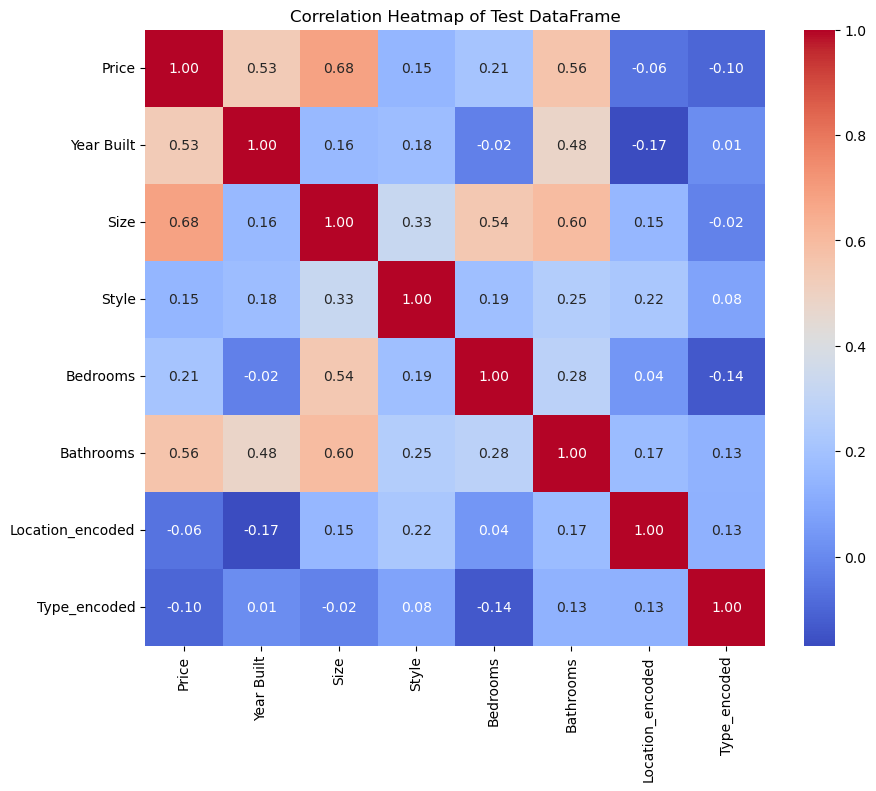

In [465]:
# Check the data types of the columns in the test dataframe
print(test.dtypes)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Test DataFrame')
plt.show()

In [178]:
y = test['Location_encoded']
X = test[[ 'Size', 'Style','Bathrooms']]

In [179]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [180]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [181]:
# Train the model on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [182]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

In [183]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.2879581151832461


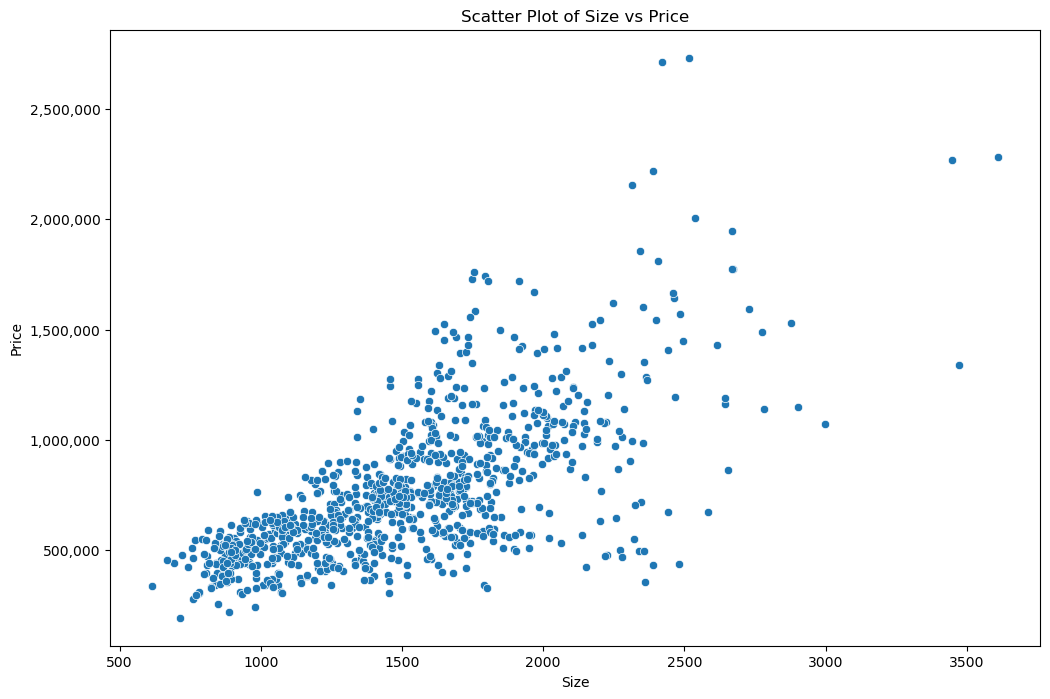

In [472]:
# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Size', y='Price', data=House_data)

# Adding labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Scatter Plot of Size vs Price')

# Set formatter for price axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Show plot
plt.show()

In [184]:
# Filter the DataFrame to keep rows where size is less than or equal to 3000
House_data = House_data[House_data['Size'] <= 3000]
House_data

,Date of Sale,Location,Price,Year Built,Size,Type,Style,Bedrooms,Bathrooms
0,06/01/2020,West End,732986,2010,1696,Detached,2,3,2
1,06/01/2020,West End,985889,2004,2355,Detached,2,4,2
2,07/01/2020,Brookville,1047124,2013,1836,Detached,2,3,2
3,07/01/2020,Brookville,516439,2000,1000,Detached,1,3,1
4,16/01/2020,Brookville,890423,2011,1536,Detached,1,3,2
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,Rivermount,466443,1936,1240,Detached,1,3,1
1005,24/12/2023,Clarawood,662985,1970,1499,Detached,1,3,2
1006,24/12/2023,Clarawood,639980,1969,1525,Detached,1,2,1
1007,31/12/2023,Maple Ridge,1131122,2016,1339,Semi-Detached,1,2,2


In [185]:
y = test['Location_encoded']
X = test[[ 'Size', 'Style', 'Bedrooms', 'Bathrooms', 'Type_encoded']]
#X = test[[ 'Size', 'Style','Bathrooms']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model on the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4397905759162304


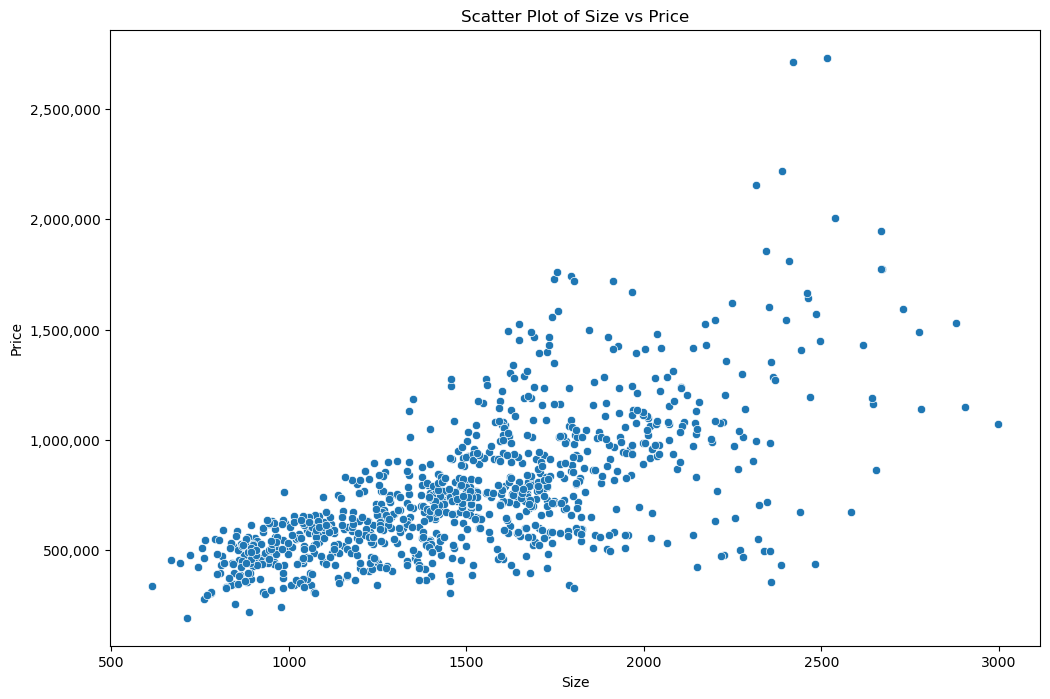

In [186]:
# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Size', y='Price', data=House_data)

# Adding labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Scatter Plot of Size vs Price')

# Set formatter for price axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Show plot
plt.show()

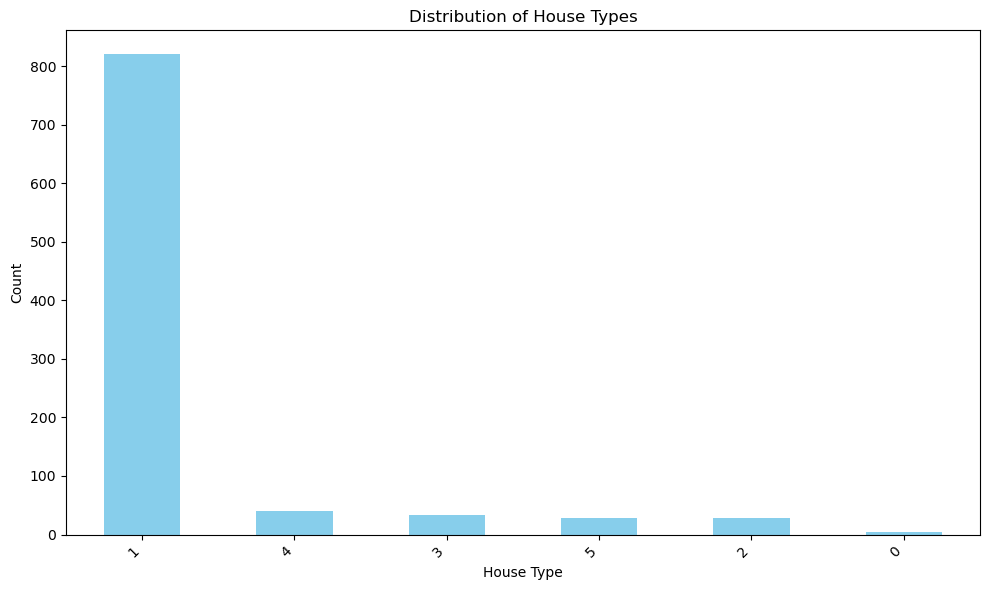

In [187]:
# Count the occurrences of each house type
house_type_counts = test['Type_encoded'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
house_type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of House Types')
plt.xlabel('House Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


In [188]:
print(test['Type_encoded'].unique())

[1 5 4 0 2 3]


In [189]:
# Filter out rows where 'type_encoded' is 0
test = test[test['Type_encoded'] != 0]

# Confirm the changes
test


,Date of Sale,Price,Year Built,Size,Style,Bedrooms,Bathrooms,Location_encoded,Type_encoded
0,06/01/2020,732986,2010,1696,2,3,2,6,1
1,06/01/2020,985889,2004,2355,2,4,2,6,1
2,07/01/2020,1047124,2013,1836,2,3,2,0,1
3,07/01/2020,516439,2000,1000,1,3,1,0,1
4,16/01/2020,890423,2011,1536,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,466443,1936,1240,1,3,1,5,1
1005,24/12/2023,662985,1970,1499,1,3,2,1,1
1006,24/12/2023,639980,1969,1525,1,2,1,1,1
1007,31/12/2023,1131122,2016,1339,1,2,2,2,4


In [190]:
y = test['Location_encoded']
X = test[[ 'Size', 'Style', 'Bedrooms', 'Bathrooms', 'Type_encoded']]
#X = test[[ 'Size', 'Style','Bathrooms']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model on the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.45549738219895286


Date of Sale        object
Price                int64
Year Built           Int64
Size                 int64
Style                int64
Bedrooms             Int64
Bathrooms            Int64
Location_encoded     int32
Type_encoded         int32
dtype: object


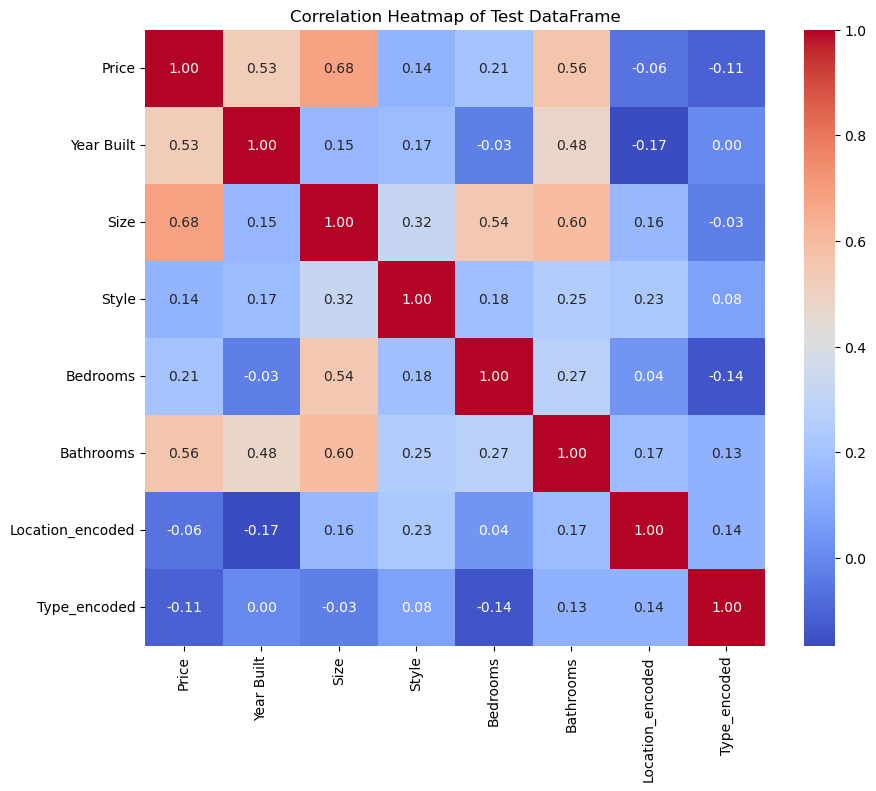

In [191]:
# Check the data types of the columns in the test dataframe
print(test.dtypes)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Test DataFrame')
plt.show()

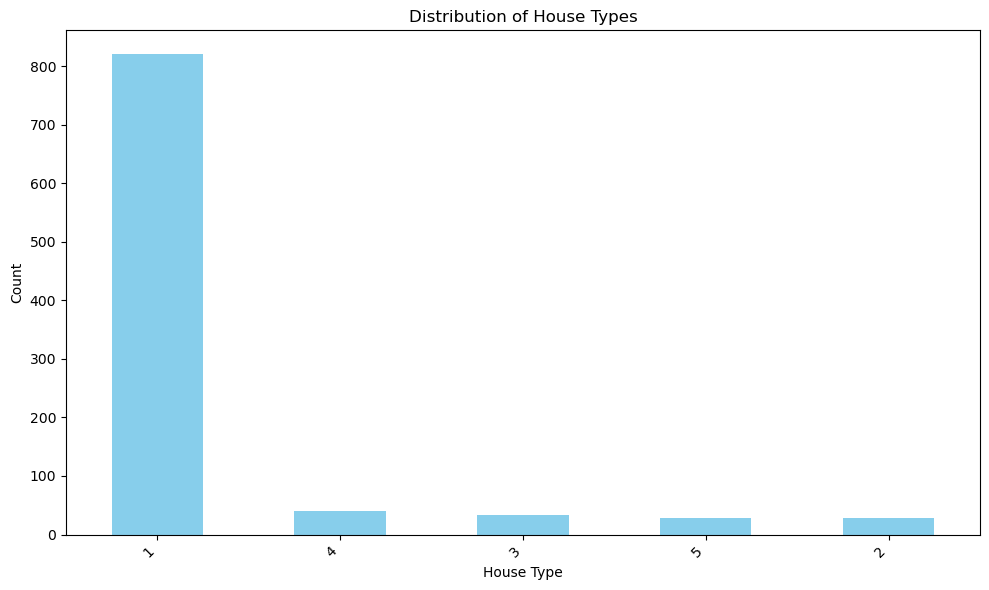

In [192]:
# Count the occurrences of each house type
house_type_counts = test['Type_encoded'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
house_type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of House Types')
plt.xlabel('House Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


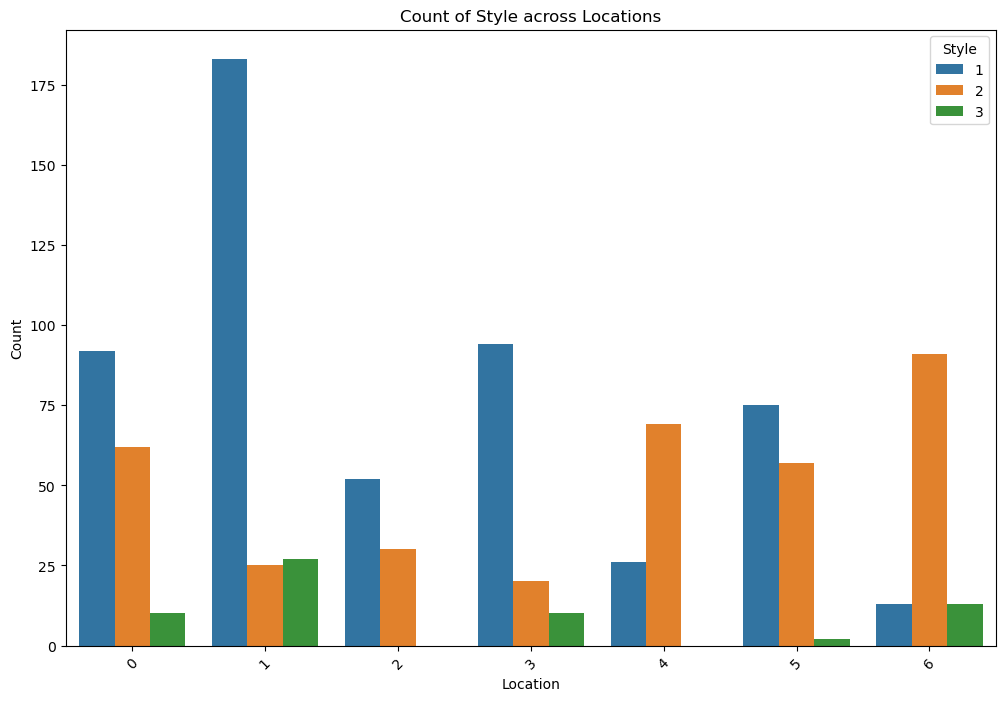

In [193]:
# Create count plot to visualize the distribution of Style across Location categories
plt.figure(figsize=(12, 8))
sns.countplot(x='Location_encoded', hue='Style', data=test)

# Adding labels and title
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Count of Style across Locations')

# Show plot
plt.legend(title='Style')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [194]:
# Count each type of style
style_counts = test['Style'].value_counts()

# Display the counts
print(style_counts)

1    535
2    354
3     62
Name: Style, dtype: int64


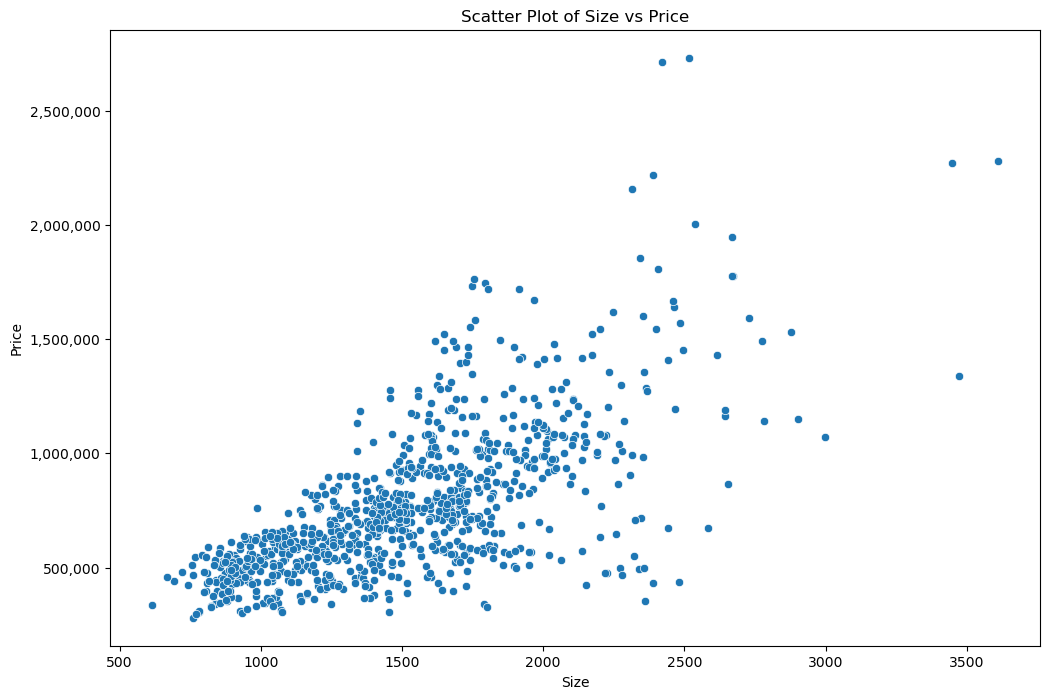

In [195]:
# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Size', y='Price', data=test)

# Adding labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Scatter Plot of Size vs Price')

# Set formatter for price axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Show plot
plt.show()

In [196]:
y = test['Location_encoded']
X = test[[ 'Size','Style','Bedrooms', 'Bathrooms', 'Type_encoded']]
#X = test[[ 'Size', 'Style','Bathrooms']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)
# Initialize the Random Forest Classifier7
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=25)
# Train the model on the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4965034965034965


In [197]:
y = test['Location_encoded']
X = test[[ 'Size', 'Style', 'Bathrooms', 'Type_encoded']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use scaler fitted on training data to transform test data
# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
# Train the model on the training data
knn.fit(X_train_scaled, y_train)
# Make predictions on the testing data
y_pred = knn.predict(X_test_scaled)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.4293193717277487


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [198]:
y = test['Location_encoded']
X = test[[ 'Size','Style','Bedrooms', 'Bathrooms', 'Type_encoded']]
#X = test[[ 'Size', 'Style','Bathrooms']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
# Initialize the Random Forest Classifier7
rf_classifier = RandomForestClassifier(n_estimators=250, random_state=25)
# Train the model on the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4607329842931937


In [199]:
# Count the unique values of bedrooms
bedrooms_count = test['Bedrooms'].value_counts()

# Display the count of unique values
print(bedrooms_count)


3    579
2    216
4    142
5     14
Name: Bedrooms, dtype: Int64


Date of Sale        object
Price                int64
Year Built           Int64
Size                 int64
Style                int64
Bedrooms             Int64
Bathrooms            Int64
Location_encoded     int32
Type_encoded         int32
dtype: object


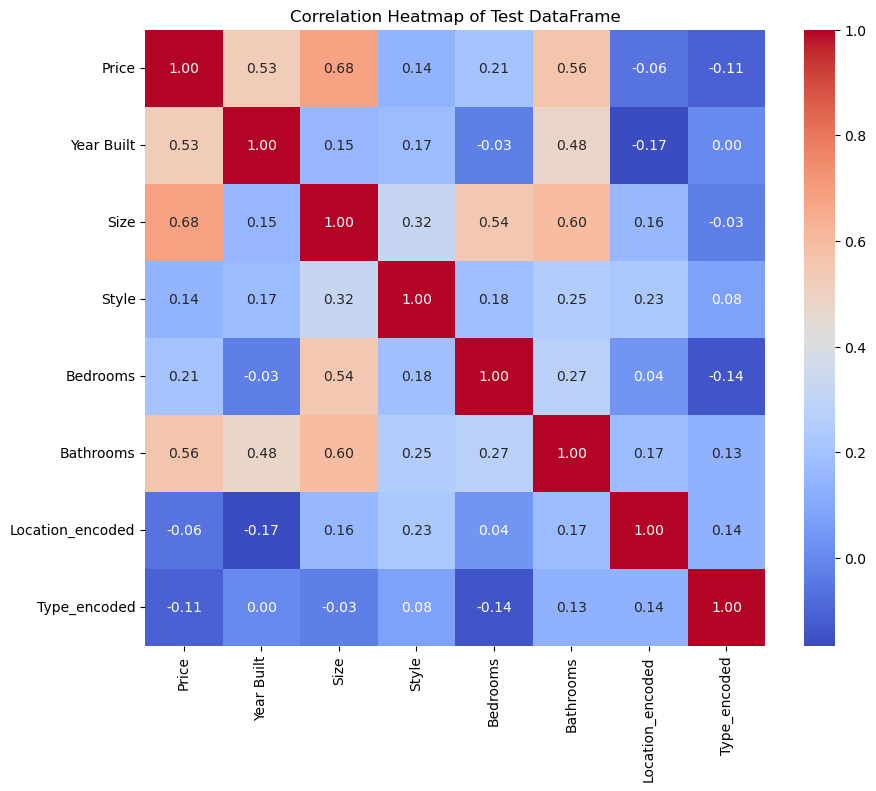

In [200]:
# Check the data types of the columns in the test dataframe
print(test.dtypes)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Test DataFrame')
plt.show()

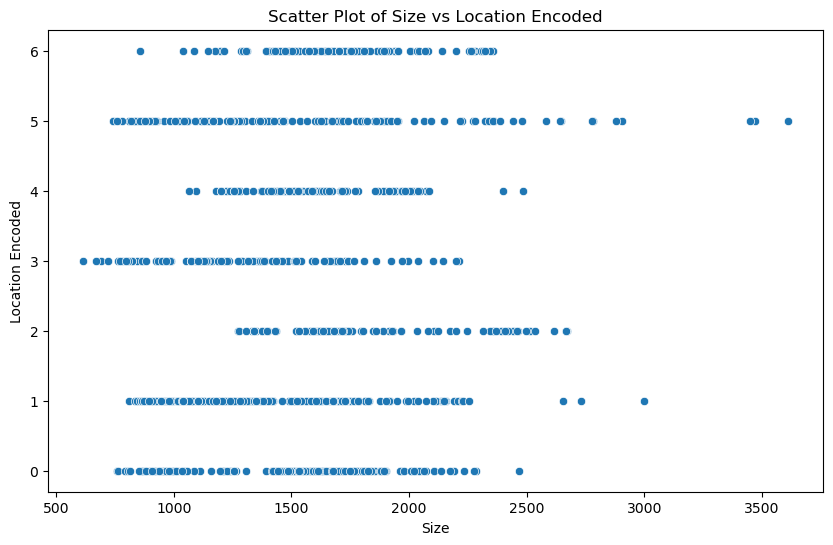

In [201]:
# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Size', y='Location_encoded', data=test)

# Adding labels and title
plt.xlabel('Size')
plt.ylabel('Location Encoded')
plt.title('Scatter Plot of Size vs Location Encoded')

# Show plot
plt.show()

Date of Sale        object
Price                int64
Year Built           Int64
Size                 int64
Style                int64
Bedrooms             Int64
Bathrooms            Int64
Location_encoded     int32
Type_encoded         int32
dtype: object


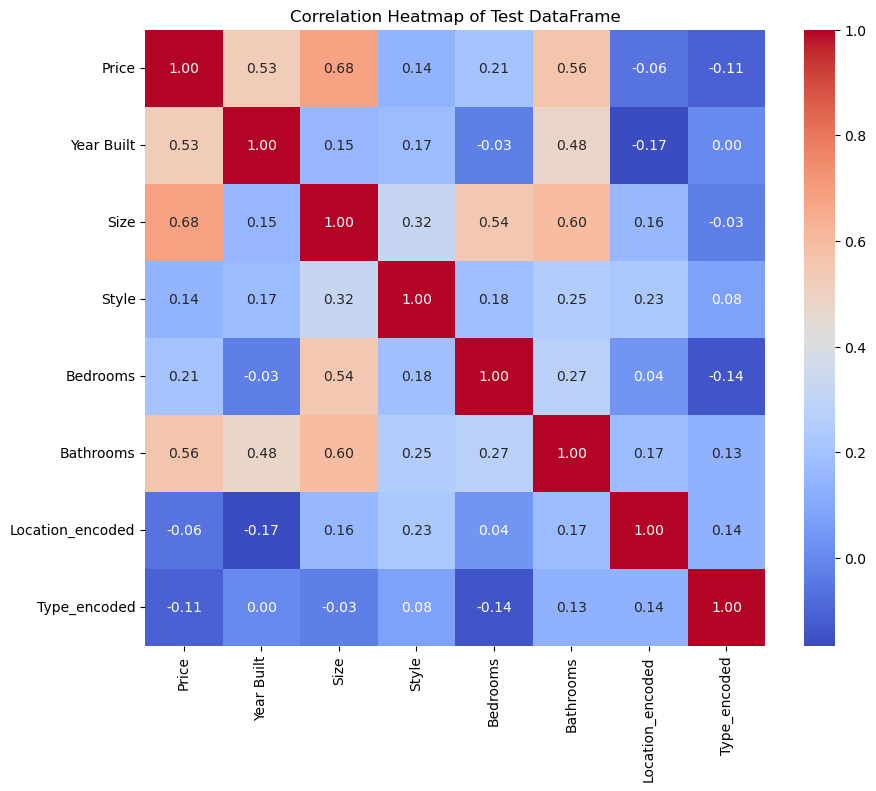

In [202]:
# Check the data types of the columns in the test dataframe
print(test.dtypes)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Test DataFrame')
plt.show()

In [203]:
test

,Date of Sale,Price,Year Built,Size,Style,Bedrooms,Bathrooms,Location_encoded,Type_encoded
0,06/01/2020,732986,2010,1696,2,3,2,6,1
1,06/01/2020,985889,2004,2355,2,4,2,6,1
2,07/01/2020,1047124,2013,1836,2,3,2,0,1
3,07/01/2020,516439,2000,1000,1,3,1,0,1
4,16/01/2020,890423,2011,1536,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...
1004,20/12/2023,466443,1936,1240,1,3,1,5,1
1005,24/12/2023,662985,1970,1499,1,3,2,1,1
1006,24/12/2023,639980,1969,1525,1,2,1,1,1
1007,31/12/2023,1131122,2016,1339,1,2,2,2,4


In [204]:
# 1. Extracting Date Components
test['Date of Sale'] = pd.to_datetime(test['Date of Sale'])
test['Sale Year'] = test['Date of Sale'].dt.year
test['Sale Month'] = test['Date of Sale'].dt.month
test['Sale Day'] = test['Date of Sale'].dt.day

# 2. Age of Property
test['Age of Property'] = test['Sale Year'] - test['Year Built']

# 3. Total Rooms
test['Total Rooms'] = test['Bedrooms'] + test['Bathrooms']

# 4. Size per Room
test['Size per Room'] = test['Size'] / test['Total Rooms']

# Drop the original "Date of Sale" column as it's no longer needed
test.drop('Date of Sale', axis=1, inplace=True)
test

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '24/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/02/2020' in DD/MM/YYYY format. Provide format or specif

,Price,Year Built,Size,Style,Bedrooms,Bathrooms,Location_encoded,Type_encoded,Sale Year,Sale Month,Sale Day,Age of Property,Total Rooms,Size per Room
0,732986,2010,1696,2,3,2,6,1,2020,6,1,10,5,339.2
1,985889,2004,2355,2,4,2,6,1,2020,6,1,16,6,392.5
2,1047124,2013,1836,2,3,2,0,1,2020,7,1,7,5,367.2
3,516439,2000,1000,1,3,1,0,1,2020,7,1,20,4,250.0
4,890423,2011,1536,1,3,2,0,1,2020,1,16,9,5,307.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,466443,1936,1240,1,3,1,5,1,2023,12,20,87,4,310.0
1005,662985,1970,1499,1,3,2,1,1,2023,12,24,53,5,299.8
1006,639980,1969,1525,1,2,1,1,1,2023,12,24,54,3,508.333333
1007,1131122,2016,1339,1,2,2,2,4,2023,12,31,7,4,334.75


Price                 int64
Year Built            Int64
Size                  int64
Style                 int64
Bedrooms              Int64
Bathrooms             Int64
Location_encoded      int32
Type_encoded          int32
Sale Year             int64
Sale Month            int64
Sale Day              int64
Age of Property       Int64
Total Rooms           Int64
Size per Room       Float64
dtype: object


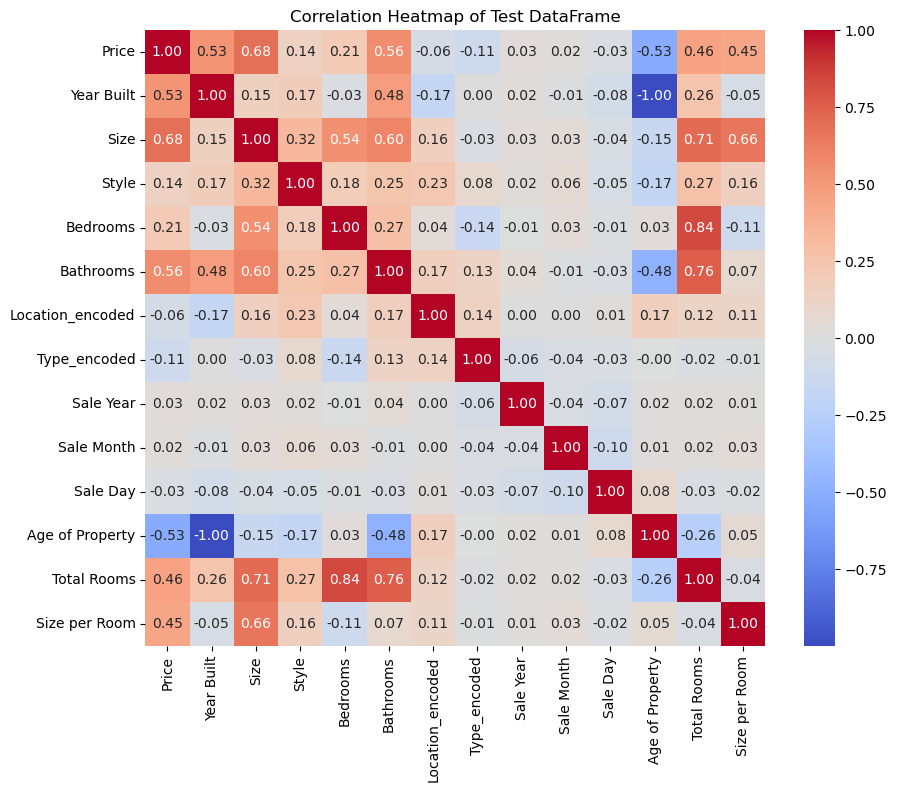

In [205]:
# Check the data types of the columns in the test dataframe
print(test.dtypes)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Test DataFrame')
plt.show()

In [212]:
print(test.columns)

Index(['Price', 'Year Built', 'Size', 'Style', 'Bedrooms', 'Bathrooms',
       'Location_encoded', 'Type_encoded', 'Sale Year', 'Sale Month',
       'Sale Day', 'Age of Property', 'Total Rooms', 'Size per Room'],
      dtype='object')


In [213]:
print(test.isnull().sum())


Price                0
Year Built          19
Size                 0
Style                0
Bedrooms             0
Bathrooms            0
Location_encoded     0
Type_encoded         0
Sale Year            0
Sale Month           0
Sale Day             0
Age of Property     19
Total Rooms          0
Size per Room        0
dtype: int64


In [214]:
test.dropna(inplace=True)


C:\Users\HP\AppData\Local\Temp\ipykernel_18992\1474856954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace=True)


In [215]:

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
X_imputed = imputer.fit_transform(X_train)

In [216]:
y = test['Location_encoded']
X = test[[ 'Size','Style', 'Bathrooms', 'Type_encoded','Age of Property', 'Total Rooms', 'Size per Room']]
#X = test[[ 'Size', 'Style','Bathrooms']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
# Initialize the Random Forest Classifier7
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=25)
# Train the model on the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5989304812834224


In [217]:
# Creating Interaction Terms
test['Size_Style_Interact'] = test['Size'] * test['Style']
test['Bedrooms_Bathrooms_Interact'] = test['Bedrooms'] * test['Bathrooms']
test['Location_Type_Interact'] = test['Location_encoded'] * test['Type_encoded']

# Binning/Categorization
# Binning property size into categories
size_bins = [0, 1000, 2000, 3000, np.inf]
size_labels = ['Small', 'Medium', 'Large', 'Very Large']
test['Size_Category'] = pd.cut(test['Size'], bins=size_bins, labels=size_labels, right=False)

# Binning property age into categories
age_bins = [0, 10, 20, 30, np.inf]
age_labels = ['New', 'Medium-Aged', 'Old', 'Very Old']
test['Age_Category'] = pd.cut(test['Year Built'], bins=age_bins, labels=age_labels, right=False)

# Print the modified dataframe
test

C:\Users\HP\AppData\Local\Temp\ipykernel_18992\514557961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Size_Style_Interact'] = test['Size'] * test['Style']
C:\Users\HP\AppData\Local\Temp\ipykernel_18992\514557961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Bedrooms_Bathrooms_Interact'] = test['Bedrooms'] * test['Bathrooms']
C:\Users\HP\AppData\Local\Temp\ipykernel_18992\514557961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,Price,Year Built,Size,Style,Bedrooms,Bathrooms,Location_encoded,Type_encoded,Sale Year,Sale Month,Sale Day,Age of Property,Total Rooms,Size per Room,Size_Style_Interact,Bedrooms_Bathrooms_Interact,Location_Type_Interact,Size_Category,Age_Category
Date of Sale,,,,,,,,,,,,,,,,,,,
2020-06-01,732986,2010,1696,2,3,2,6,1,2020,6,1,10,5,339.2,3392,6,6,Medium,Very Old
2020-06-01,985889,2004,2355,2,4,2,6,1,2020,6,1,16,6,392.5,4710,8,6,Large,Very Old
2020-07-01,1047124,2013,1836,2,3,2,0,1,2020,7,1,7,5,367.2,3672,6,0,Medium,Very Old
2020-07-01,516439,2000,1000,1,3,1,0,1,2020,7,1,20,4,250.0,1000,3,0,Medium,Very Old
2020-01-01,890423,2011,1536,1,3,2,0,1,2020,1,16,9,5,307.2,1536,6,0,Medium,Very Old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,466443,1936,1240,1,3,1,5,1,2023,12,20,87,4,310.0,1240,3,5,Medium,Very Old
2023-12-01,662985,1970,1499,1,3,2,1,1,2023,12,24,53,5,299.8,1499,6,1,Medium,Very Old
2023-12-01,639980,1969,1525,1,2,1,1,1,2023,12,24,54,3,508.333333,1525,2,1,Medium,Very Old


In [218]:
# Label encoding for Size_Category and Age_Category
label_encoder = LabelEncoder()
test['Size_Category_Encoded'] = label_encoder.fit_transform(test['Size_Category'])
test['Age_Category_Encoded'] = label_encoder.fit_transform(test['Age_Category'])

# Drop the original categorical columns
test.drop(['Size_Category', 'Age_Category'], axis=1, inplace=True)

# Print the modified dataframe
test

C:\Users\HP\AppData\Local\Temp\ipykernel_18992\3935005610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Size_Category_Encoded'] = label_encoder.fit_transform(test['Size_Category'])
C:\Users\HP\AppData\Local\Temp\ipykernel_18992\3935005610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Age_Category_Encoded'] = label_encoder.fit_transform(test['Age_Category'])
C:\Users\HP\AppData\Local\Temp\ipykernel_18992\3935005610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,Price,Year Built,Size,Style,Bedrooms,Bathrooms,Location_encoded,Type_encoded,Sale Year,Sale Month,Sale Day,Age of Property,Total Rooms,Size per Room,Size_Style_Interact,Bedrooms_Bathrooms_Interact,Location_Type_Interact,Size_Category_Encoded,Age_Category_Encoded
Date of Sale,,,,,,,,,,,,,,,,,,,
2020-06-01,732986,2010,1696,2,3,2,6,1,2020,6,1,10,5,339.2,3392,6,6,1,0
2020-06-01,985889,2004,2355,2,4,2,6,1,2020,6,1,16,6,392.5,4710,8,6,0,0
2020-07-01,1047124,2013,1836,2,3,2,0,1,2020,7,1,7,5,367.2,3672,6,0,1,0
2020-07-01,516439,2000,1000,1,3,1,0,1,2020,7,1,20,4,250.0,1000,3,0,1,0
2020-01-01,890423,2011,1536,1,3,2,0,1,2020,1,16,9,5,307.2,1536,6,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,466443,1936,1240,1,3,1,5,1,2023,12,20,87,4,310.0,1240,3,5,1,0
2023-12-01,662985,1970,1499,1,3,2,1,1,2023,12,24,53,5,299.8,1499,6,1,1,0
2023-12-01,639980,1969,1525,1,2,1,1,1,2023,12,24,54,3,508.333333,1525,2,1,1,0


Price                            int64
Year Built                       Int64
Size                             int64
Style                            int64
Bedrooms                         Int64
Bathrooms                        Int64
Location_encoded                 int32
Type_encoded                     int32
Sale Year                        int64
Sale Month                       int64
Sale Day                         int64
Age of Property                  Int64
Total Rooms                      Int64
Size per Room                  Float64
Size_Style_Interact              int64
Bedrooms_Bathrooms_Interact      Int64
Location_Type_Interact           int32
Size_Category_Encoded            int32
Age_Category_Encoded             int32
dtype: object


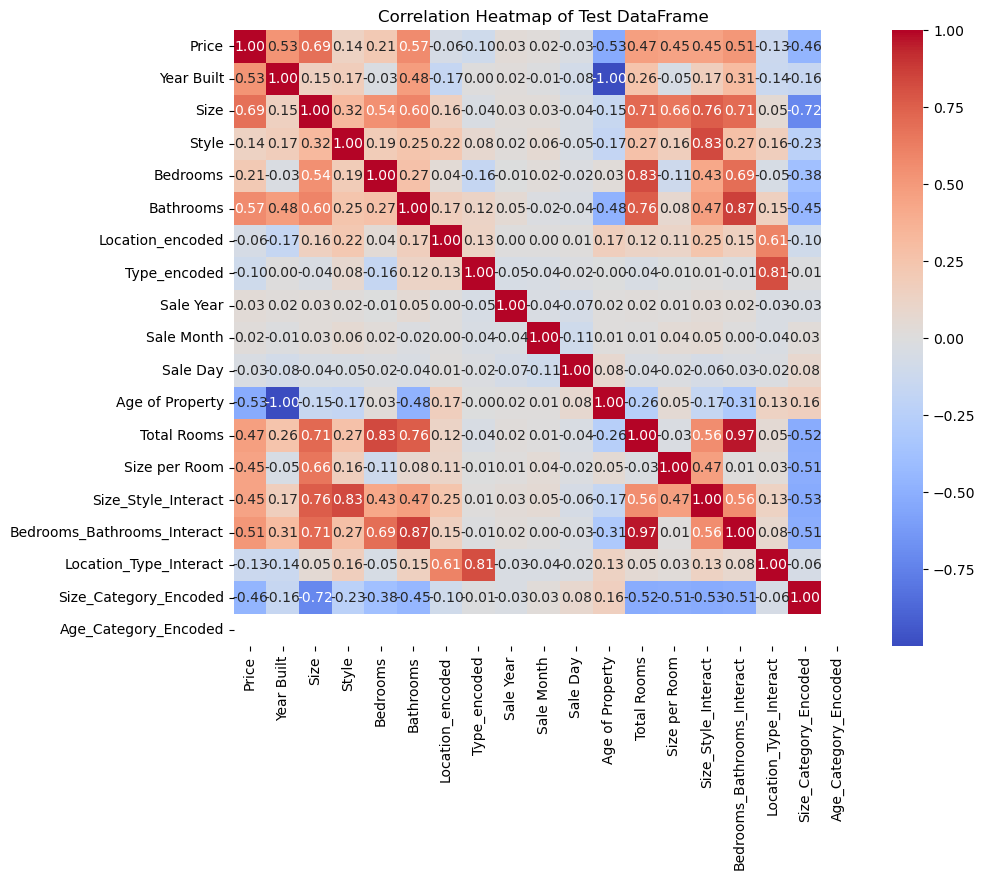

In [219]:
# Check the data types of the columns in the test dataframe
print(test.dtypes)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Test DataFrame')
plt.show()

In [220]:
print(test.columns)

Index(['Price', 'Year Built', 'Size', 'Style', 'Bedrooms', 'Bathrooms',
       'Location_encoded', 'Type_encoded', 'Sale Year', 'Sale Month',
       'Sale Day', 'Age of Property', 'Total Rooms', 'Size per Room',
       'Size_Style_Interact', 'Bedrooms_Bathrooms_Interact',
       'Location_Type_Interact', 'Size_Category_Encoded',
       'Age_Category_Encoded'],
      dtype='object')


In [221]:
y = test['Location_encoded']
X = test[[ 'Size','Style', 'Bathrooms', 'Type_encoded','Age of Property', 'Total Rooms', 'Size per Room','Size_Style_Interact', 'Bedrooms_Bathrooms_Interact',
       'Location_Type_Interact']]
#X = test[[ 'Size', 'Style','Bathrooms']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
# Initialize the Random Forest Classifier7
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=25)
# Train the model on the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9625668449197861


In [222]:
confusion_matrix(y_test,y_pred)

array([[25,  0,  0,  0,  0,  0,  0],
       [ 0, 47,  0,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0,  0,  0],
       [ 0,  0,  1, 25,  1,  3,  0],
       [ 0,  0,  1,  0, 14,  0,  0],
       [ 0,  0,  0,  1,  0, 25,  0],
       [ 0,  0,  0,  0,  0,  0, 24]], dtype=int64)

In [223]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        47
           2       0.91      1.00      0.95        20
           3       0.96      0.83      0.89        30
           4       0.93      0.93      0.93        15
           5       0.89      0.96      0.93        26
           6       1.00      1.00      1.00        24

    accuracy                           0.96       187
   macro avg       0.96      0.96      0.96       187
weighted avg       0.96      0.96      0.96       187



## SUBSET 

In [224]:
# Define different subsets of descriptive features
feature_subsets = [
    ['Size', 'Style', 'Bedrooms', 'Bathrooms'],
    ['Location_encoded', 'Type_encoded', 'Sale Year', 'Sale Month', 'Sale Day'],
    ['Age of Property', 'Total Rooms', 'Size per Room'],
    ['Size_Style_Interact', 'Bedrooms_Bathrooms_Interact', 'Location_Type_Interact'],
    ['Size_Category_Encoded', 'Age_Category_Encoded'],
    # Add more feature subsets as needed
]

# Target variable
y = test['Location_encoded']

# Initialize a dictionary to store accuracy scores for each feature subset
accuracy_scores = {}

# Initialize dictionaries to store confusion matrices and classification reports
confusion_matrices = {}
classification_reports = {}

# Iterate over each feature subset
for i, features in enumerate(feature_subsets, start=1):
    # Select features from the DataFrame
    X = test[features]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
    
    # Initialize the Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=250, random_state=25)
    
    # Train the model on the training data
    rf_classifier.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the accuracy score in the dictionary
    accuracy_scores[f'Subset {i}'] = accuracy
    
    # Calculate and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[f'Subset {i}'] = cm
    
    # Calculate and store the classification report
    cr = classification_report(y_test, y_pred)
    classification_reports[f'Subset {i}'] = cr

# Print accuracy scores for each feature subset
for subset, accuracy in accuracy_scores.items():
    print(f'{subset}: Accuracy = {accuracy:.4f}')
    print('Confusion Matrix:')
    print(confusion_matrices[subset])
    print('Classification Report:')
    print(classification_reports[subset])
    print()

Subset 1: Accuracy = 0.4011
Confusion Matrix:
[[15  2  1  1  2  2  2]
 [ 6 17  0 12  1  9  2]
 [ 2  1 11  2  1  2  1]
 [ 3  7  1 10  1  8  0]
 [ 4  1  2  1  3  1  3]
 [ 4  8  2  1  1  6  4]
 [ 5  2  0  1  0  3 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.60      0.47        25
           1       0.45      0.36      0.40        47
           2       0.65      0.55      0.59        20
           3       0.36      0.33      0.34        30
           4       0.33      0.20      0.25        15
           5       0.19      0.23      0.21        26
           6       0.52      0.54      0.53        24

    accuracy                           0.40       187
   macro avg       0.41      0.40      0.40       187
weighted avg       0.41      0.40      0.40       187


Subset 2: Accuracy = 0.9947
Confusion Matrix:
[[25  0  0  0  0  0  0]
 [ 0 47  0  0  0  0  0]
 [ 0  0 20  0  0  0  0]
 [ 0  0  0 30  0  0  0]
 [ 0  0  0  0 15  0  0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Subset 4 is performing best as subset 2 overfit 